In [23]:
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torchvision.transforms as transforms

dataset_storage_directory = './mnist_dataset'
image_resolution = (28, 28)

mnist_dataset = datasets.MNIST(
    root=dataset_storage_directory,
    train=True,
    transform=transforms.Compose([
        transforms.Resize(image_resolution),
        transforms.ToTensor()
    ]),
    download=True
)
from torch.utils.data import DataLoader

batch_size = 64
indices_of_digit_1 = [i for i, label in enumerate(mnist_dataset.targets) if label == 1]

# Create a subset of the dataset for digit '1' only
#mnist_dataset = Subset(mnist_dataset, indices_of_digit_1)
dataloader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [24]:
import torch.nn as nn
import torch

In [32]:
# class SkipConnectionModule(nn.Module):
#   def __init__(self, layers) -> None:
#     super().__init__()
#     self.layers = layers
#   def forward(self, x):
#     initial_input = x
#     for layer in self.layers:
#       x = layer(x)
#     return x + initial_input
class SkipConnectionModule(nn.Module):
  def __init__(self, layers) -> None:
    super().__init__()
    self.layers = nn.Sequential(*layers)
  def forward(self, x):
    return self.layers(x) + x
class ResNetModule(nn.Module):
  def __init__(self, input_channels=1, base_filter_dimension=64, output_dim=10):
    super().__init__()
    self.conv_layer = nn.Conv2d(input_channels, base_filter_dimension, kernel_size=3, stride=1, padding=1)
    self.conv_layer_same_io = nn.Conv2d(base_filter_dimension, base_filter_dimension, kernel_size=3, stride=1, padding=1)
    self.second_conv_layer = nn.Conv2d(base_filter_dimension, base_filter_dimension * 2, kernel_size=3, stride=1, padding=1)
    self.second_conv_layer_same_io = nn.Conv2d(base_filter_dimension * 2, base_filter_dimension * 2, kernel_size=3, stride=1, padding=1)
    self.batch_norm_layer = nn.BatchNorm2d(base_filter_dimension)
    self.second_batch_norm_layer = nn.BatchNorm2d(base_filter_dimension * 2)
    self.relu_layer = nn.ReLU()
    self.relu_layer2 = nn.ReLU()
    self.max_pool_layer = nn.MaxPool2d(kernel_size=3, stride=2, padding=0)
    self.first_layer = SkipConnectionModule([self.conv_layer_same_io, self.batch_norm_layer, self.relu_layer])
    self.second_layer = SkipConnectionModule([self.second_conv_layer_same_io, self.second_batch_norm_layer, self.relu_layer2])
    self.average_pooling_layer = nn.AdaptiveAvgPool2d((1,1))
    self.flattening_layer = torch.flatten
    self.final_fully_connected = nn.Linear(base_filter_dimension * 2, output_dim)
  def forward(self, x):
    x = self.conv_layer(x)
    x = self.first_layer(x)
    x = self.max_pool_layer(x)
    x = self.second_conv_layer(x)
    x = self.second_layer(x)
    x = self.max_pool_layer(x)
    x = self.average_pooling_layer(x)
    x = self.flattening_layer(x, 1)
    return self.final_fully_connected(x)

In [33]:
model = ResNetModule()

In [34]:
from tqdm import tqdm
EPOCHS = 10
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
optimizer = torch.optim.Adam(model.parameters())
loss = nn.CrossEntropyLoss()
for epoch in range(0, 1):
  for image_batch, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}"):
    image_batch = image_batch.to(device)
    model_output = model(image_batch)
    output = loss(model_output, labels.to(device))
    print(output)
    output.backward()
    optimizer.step()
    optimizer.zero_grad()

Epoch 1:   0%|          | 0/937 [00:00<?, ?it/s]

tensor(2.6784, grad_fn=<NllLossBackward0>)


Epoch 1:   0%|          | 1/937 [00:00<09:55,  1.57it/s]

tensor(2.5057, grad_fn=<NllLossBackward0>)


Epoch 1:   0%|          | 2/937 [00:01<09:55,  1.57it/s]

tensor(2.2412, grad_fn=<NllLossBackward0>)


Epoch 1:   0%|          | 3/937 [00:01<09:53,  1.57it/s]

tensor(2.5924, grad_fn=<NllLossBackward0>)


Epoch 1:   0%|          | 4/937 [00:02<09:52,  1.57it/s]

tensor(2.2434, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|          | 5/937 [00:03<09:47,  1.59it/s]

tensor(2.2495, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|          | 6/937 [00:03<09:46,  1.59it/s]

tensor(2.1120, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|          | 7/937 [00:04<09:46,  1.59it/s]

tensor(2.1308, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|          | 8/937 [00:05<09:43,  1.59it/s]

tensor(2.2657, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|          | 9/937 [00:05<09:48,  1.58it/s]

tensor(2.0567, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|          | 10/937 [00:06<09:47,  1.58it/s]

tensor(1.9570, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|          | 11/937 [00:06<09:52,  1.56it/s]

tensor(2.0155, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|▏         | 12/937 [00:07<09:51,  1.56it/s]

tensor(1.9621, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|▏         | 13/937 [00:08<09:46,  1.57it/s]

tensor(1.8339, grad_fn=<NllLossBackward0>)


Epoch 1:   1%|▏         | 14/937 [00:08<09:45,  1.58it/s]

tensor(1.8109, grad_fn=<NllLossBackward0>)


Epoch 1:   2%|▏         | 15/937 [00:09<10:58,  1.40it/s]

tensor(1.9095, grad_fn=<NllLossBackward0>)


Epoch 1:   2%|▏         | 16/937 [00:10<12:25,  1.24it/s]

tensor(1.7500, grad_fn=<NllLossBackward0>)


Epoch 1:   2%|▏         | 17/937 [00:11<13:19,  1.15it/s]

tensor(1.8323, grad_fn=<NllLossBackward0>)


Epoch 1:   2%|▏         | 18/937 [00:12<12:19,  1.24it/s]

tensor(1.7328, grad_fn=<NllLossBackward0>)


Epoch 1:   2%|▏         | 19/937 [00:13<11:32,  1.32it/s]

tensor(1.7140, grad_fn=<NllLossBackward0>)


Epoch 1:   2%|▏         | 20/937 [00:13<10:57,  1.39it/s]

tensor(1.7394, grad_fn=<NllLossBackward0>)


Epoch 1:   2%|▏         | 21/937 [00:14<10:34,  1.44it/s]

tensor(1.6471, grad_fn=<NllLossBackward0>)


Epoch 1:   2%|▏         | 22/937 [00:15<10:18,  1.48it/s]

tensor(1.6837, grad_fn=<NllLossBackward0>)


Epoch 1:   2%|▏         | 23/937 [00:15<09:53,  1.54it/s]

tensor(1.6109, grad_fn=<NllLossBackward0>)


Epoch 1:   3%|▎         | 24/937 [00:16<09:47,  1.55it/s]

tensor(1.5665, grad_fn=<NllLossBackward0>)


Epoch 1:   3%|▎         | 25/937 [00:16<09:44,  1.56it/s]

tensor(1.5804, grad_fn=<NllLossBackward0>)


Epoch 1:   3%|▎         | 26/937 [00:17<09:40,  1.57it/s]

tensor(1.6709, grad_fn=<NllLossBackward0>)


Epoch 1:   3%|▎         | 27/937 [00:18<09:41,  1.57it/s]

tensor(1.5115, grad_fn=<NllLossBackward0>)


Epoch 1:   3%|▎         | 28/937 [00:18<09:34,  1.58it/s]

tensor(1.4430, grad_fn=<NllLossBackward0>)


Epoch 1:   3%|▎         | 29/937 [00:19<10:08,  1.49it/s]

tensor(1.5210, grad_fn=<NllLossBackward0>)


Epoch 1:   3%|▎         | 30/937 [00:20<10:00,  1.51it/s]

tensor(1.3771, grad_fn=<NllLossBackward0>)


Epoch 1:   3%|▎         | 31/937 [00:20<09:48,  1.54it/s]

tensor(1.5886, grad_fn=<NllLossBackward0>)


Epoch 1:   3%|▎         | 32/937 [00:21<09:40,  1.56it/s]

tensor(1.3941, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▎         | 33/937 [00:22<10:00,  1.51it/s]

tensor(1.3553, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▎         | 34/937 [00:23<11:36,  1.30it/s]

tensor(1.3503, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▎         | 35/937 [00:24<12:24,  1.21it/s]

tensor(1.3750, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▍         | 36/937 [00:24<12:38,  1.19it/s]

tensor(1.3399, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▍         | 37/937 [00:25<11:39,  1.29it/s]

tensor(1.4381, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▍         | 38/937 [00:26<10:58,  1.37it/s]

tensor(1.3747, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▍         | 39/937 [00:26<10:36,  1.41it/s]

tensor(1.3906, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▍         | 40/937 [00:27<10:15,  1.46it/s]

tensor(1.3065, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▍         | 41/937 [00:28<10:04,  1.48it/s]

tensor(1.2372, grad_fn=<NllLossBackward0>)


Epoch 1:   4%|▍         | 42/937 [00:28<09:52,  1.51it/s]

tensor(1.2598, grad_fn=<NllLossBackward0>)


Epoch 1:   5%|▍         | 43/937 [00:29<09:44,  1.53it/s]

tensor(1.2149, grad_fn=<NllLossBackward0>)


Epoch 1:   5%|▍         | 44/937 [00:30<09:38,  1.54it/s]

tensor(1.3040, grad_fn=<NllLossBackward0>)


Epoch 1:   5%|▍         | 45/937 [00:30<09:37,  1.55it/s]

tensor(1.0769, grad_fn=<NllLossBackward0>)


Epoch 1:   5%|▍         | 46/937 [00:31<09:31,  1.56it/s]

tensor(1.1103, grad_fn=<NllLossBackward0>)


Epoch 1:   5%|▌         | 47/937 [00:31<09:30,  1.56it/s]

tensor(1.2237, grad_fn=<NllLossBackward0>)


Epoch 1:   5%|▌         | 48/937 [00:32<09:18,  1.59it/s]

tensor(1.2028, grad_fn=<NllLossBackward0>)


Epoch 1:   5%|▌         | 49/937 [00:33<09:20,  1.58it/s]

tensor(1.0527, grad_fn=<NllLossBackward0>)


Epoch 1:   5%|▌         | 50/937 [00:33<09:22,  1.58it/s]

tensor(1.1385, grad_fn=<NllLossBackward0>)


Epoch 1:   5%|▌         | 51/937 [00:34<09:19,  1.58it/s]

tensor(1.2648, grad_fn=<NllLossBackward0>)


Epoch 1:   6%|▌         | 52/937 [00:35<10:25,  1.41it/s]

tensor(1.2386, grad_fn=<NllLossBackward0>)


Epoch 1:   6%|▌         | 53/937 [00:36<11:39,  1.26it/s]

tensor(1.1844, grad_fn=<NllLossBackward0>)


Epoch 1:   6%|▌         | 54/937 [00:37<12:42,  1.16it/s]

tensor(1.3198, grad_fn=<NllLossBackward0>)


Epoch 1:   6%|▌         | 55/937 [00:38<12:02,  1.22it/s]

tensor(1.0250, grad_fn=<NllLossBackward0>)


Epoch 1:   6%|▌         | 56/937 [00:38<11:12,  1.31it/s]

tensor(1.1978, grad_fn=<NllLossBackward0>)


Epoch 1:   6%|▌         | 57/937 [00:39<10:35,  1.38it/s]

tensor(0.9720, grad_fn=<NllLossBackward0>)


Epoch 1:   6%|▌         | 58/937 [00:39<10:14,  1.43it/s]

tensor(1.2103, grad_fn=<NllLossBackward0>)


Epoch 1:   6%|▋         | 59/937 [00:40<09:53,  1.48it/s]

tensor(1.1268, grad_fn=<NllLossBackward0>)


Epoch 1:   6%|▋         | 60/937 [00:41<09:41,  1.51it/s]

tensor(0.8768, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 61/937 [00:41<09:35,  1.52it/s]

tensor(0.9575, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 62/937 [00:42<09:25,  1.55it/s]

tensor(1.0423, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 63/937 [00:43<09:23,  1.55it/s]

tensor(0.9344, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 64/937 [00:43<09:15,  1.57it/s]

tensor(1.0165, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 65/937 [00:44<09:13,  1.57it/s]

tensor(1.0780, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 66/937 [00:45<09:12,  1.58it/s]

tensor(1.1351, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 67/937 [00:45<09:08,  1.59it/s]

tensor(1.0163, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 68/937 [00:46<09:05,  1.59it/s]

tensor(0.9303, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 69/937 [00:46<09:05,  1.59it/s]

tensor(1.0643, grad_fn=<NllLossBackward0>)


Epoch 1:   7%|▋         | 70/937 [00:47<09:06,  1.59it/s]

tensor(0.8883, grad_fn=<NllLossBackward0>)


Epoch 1:   8%|▊         | 71/937 [00:48<10:40,  1.35it/s]

tensor(0.8131, grad_fn=<NllLossBackward0>)


Epoch 1:   8%|▊         | 72/937 [00:49<11:44,  1.23it/s]

tensor(0.8700, grad_fn=<NllLossBackward0>)


Epoch 1:   8%|▊         | 73/937 [00:50<12:11,  1.18it/s]

tensor(1.0481, grad_fn=<NllLossBackward0>)


Epoch 1:   8%|▊         | 74/937 [00:51<11:13,  1.28it/s]

tensor(0.7275, grad_fn=<NllLossBackward0>)


Epoch 1:   8%|▊         | 75/937 [00:51<10:33,  1.36it/s]

tensor(0.8964, grad_fn=<NllLossBackward0>)


Epoch 1:   8%|▊         | 76/937 [00:52<10:01,  1.43it/s]

tensor(0.8391, grad_fn=<NllLossBackward0>)


Epoch 1:   8%|▊         | 77/937 [00:52<09:50,  1.46it/s]

tensor(1.0137, grad_fn=<NllLossBackward0>)


Epoch 1:   8%|▊         | 78/937 [00:53<09:38,  1.49it/s]

tensor(0.8355, grad_fn=<NllLossBackward0>)


Epoch 1:   8%|▊         | 79/937 [00:54<09:28,  1.51it/s]

tensor(0.9201, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▊         | 80/937 [00:54<09:20,  1.53it/s]

tensor(0.8213, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▊         | 81/937 [00:55<09:15,  1.54it/s]

tensor(0.8812, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▉         | 82/937 [00:56<09:10,  1.55it/s]

tensor(0.8635, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▉         | 83/937 [00:56<09:07,  1.56it/s]

tensor(0.8943, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▉         | 84/937 [00:57<09:07,  1.56it/s]

tensor(0.7860, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▉         | 85/937 [00:58<09:09,  1.55it/s]

tensor(0.7202, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▉         | 86/937 [00:58<09:03,  1.56it/s]

tensor(0.8996, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▉         | 87/937 [00:59<08:59,  1.58it/s]

tensor(0.8993, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▉         | 88/937 [00:59<08:58,  1.58it/s]

tensor(0.8380, grad_fn=<NllLossBackward0>)


Epoch 1:   9%|▉         | 89/937 [01:00<09:32,  1.48it/s]

tensor(0.8313, grad_fn=<NllLossBackward0>)


Epoch 1:  10%|▉         | 90/937 [01:01<10:56,  1.29it/s]

tensor(0.7513, grad_fn=<NllLossBackward0>)


Epoch 1:  10%|▉         | 91/937 [01:02<11:50,  1.19it/s]

tensor(0.7425, grad_fn=<NllLossBackward0>)


Epoch 1:  10%|▉         | 92/937 [01:03<11:43,  1.20it/s]

tensor(0.8088, grad_fn=<NllLossBackward0>)


Epoch 1:  10%|▉         | 93/937 [01:04<10:53,  1.29it/s]

tensor(0.7240, grad_fn=<NllLossBackward0>)


Epoch 1:  10%|█         | 94/937 [01:04<10:16,  1.37it/s]

tensor(0.7372, grad_fn=<NllLossBackward0>)


Epoch 1:  10%|█         | 95/937 [01:05<09:50,  1.43it/s]

tensor(0.8260, grad_fn=<NllLossBackward0>)


Epoch 1:  10%|█         | 96/937 [01:06<09:34,  1.46it/s]

tensor(0.7640, grad_fn=<NllLossBackward0>)


Epoch 1:  10%|█         | 97/937 [01:06<09:18,  1.51it/s]

tensor(0.8651, grad_fn=<NllLossBackward0>)


Epoch 1:  10%|█         | 98/937 [01:07<09:10,  1.52it/s]

tensor(0.9223, grad_fn=<NllLossBackward0>)


Epoch 1:  11%|█         | 99/937 [01:08<09:07,  1.53it/s]

tensor(0.8195, grad_fn=<NllLossBackward0>)


Epoch 1:  11%|█         | 100/937 [01:08<08:59,  1.55it/s]

tensor(0.6798, grad_fn=<NllLossBackward0>)


Epoch 1:  11%|█         | 101/937 [01:09<08:56,  1.56it/s]

tensor(0.6772, grad_fn=<NllLossBackward0>)


Epoch 1:  11%|█         | 102/937 [01:09<08:56,  1.56it/s]

tensor(0.8360, grad_fn=<NllLossBackward0>)


Epoch 1:  11%|█         | 103/937 [01:10<08:52,  1.57it/s]

tensor(0.9034, grad_fn=<NllLossBackward0>)


Epoch 1:  11%|█         | 104/937 [01:11<08:51,  1.57it/s]

tensor(0.6365, grad_fn=<NllLossBackward0>)


Epoch 1:  11%|█         | 105/937 [01:11<08:46,  1.58it/s]

tensor(0.7030, grad_fn=<NllLossBackward0>)


Epoch 1:  11%|█▏        | 106/937 [01:12<08:46,  1.58it/s]

tensor(0.7703, grad_fn=<NllLossBackward0>)


Epoch 1:  11%|█▏        | 107/937 [01:13<08:47,  1.57it/s]

tensor(0.7643, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 108/937 [01:13<09:48,  1.41it/s]

tensor(0.6420, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 109/937 [01:14<10:54,  1.26it/s]

tensor(0.6825, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 110/937 [01:15<11:52,  1.16it/s]

tensor(0.7298, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 111/937 [01:16<11:06,  1.24it/s]

tensor(0.5704, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 112/937 [01:17<10:24,  1.32it/s]

tensor(0.6628, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 113/937 [01:17<09:52,  1.39it/s]

tensor(0.7063, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 114/937 [01:18<09:29,  1.45it/s]

tensor(0.6925, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 115/937 [01:19<09:12,  1.49it/s]

tensor(0.6104, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 116/937 [01:19<09:00,  1.52it/s]

tensor(0.6248, grad_fn=<NllLossBackward0>)


Epoch 1:  12%|█▏        | 117/937 [01:20<08:55,  1.53it/s]

tensor(0.8190, grad_fn=<NllLossBackward0>)


Epoch 1:  13%|█▎        | 118/937 [01:21<08:47,  1.55it/s]

tensor(0.6867, grad_fn=<NllLossBackward0>)


Epoch 1:  13%|█▎        | 119/937 [01:21<08:45,  1.56it/s]

tensor(0.6143, grad_fn=<NllLossBackward0>)


Epoch 1:  13%|█▎        | 120/937 [01:22<08:44,  1.56it/s]

tensor(0.7599, grad_fn=<NllLossBackward0>)


Epoch 1:  13%|█▎        | 121/937 [01:22<08:32,  1.59it/s]

tensor(0.5773, grad_fn=<NllLossBackward0>)


Epoch 1:  13%|█▎        | 122/937 [01:23<08:32,  1.59it/s]

tensor(0.5989, grad_fn=<NllLossBackward0>)


Epoch 1:  13%|█▎        | 123/937 [01:24<08:30,  1.59it/s]

tensor(0.6836, grad_fn=<NllLossBackward0>)


Epoch 1:  13%|█▎        | 124/937 [01:24<08:29,  1.59it/s]

tensor(0.4557, grad_fn=<NllLossBackward0>)


Epoch 1:  13%|█▎        | 125/937 [01:25<08:25,  1.61it/s]

tensor(0.6056, grad_fn=<NllLossBackward0>)


Epoch 1:  13%|█▎        | 126/937 [01:26<08:24,  1.61it/s]

tensor(0.6344, grad_fn=<NllLossBackward0>)


Epoch 1:  14%|█▎        | 127/937 [01:27<09:51,  1.37it/s]

tensor(0.5526, grad_fn=<NllLossBackward0>)


Epoch 1:  14%|█▎        | 128/937 [01:28<10:53,  1.24it/s]

tensor(0.6267, grad_fn=<NllLossBackward0>)


Epoch 1:  14%|█▍        | 129/937 [01:29<11:40,  1.15it/s]

tensor(0.4961, grad_fn=<NllLossBackward0>)


Epoch 1:  14%|█▍        | 130/937 [01:29<10:41,  1.26it/s]

tensor(0.6796, grad_fn=<NllLossBackward0>)


Epoch 1:  14%|█▍        | 131/937 [01:30<09:59,  1.34it/s]

tensor(0.6154, grad_fn=<NllLossBackward0>)


Epoch 1:  14%|█▍        | 132/937 [01:30<09:33,  1.40it/s]

tensor(0.5727, grad_fn=<NllLossBackward0>)


Epoch 1:  14%|█▍        | 133/937 [01:31<09:11,  1.46it/s]

tensor(0.5771, grad_fn=<NllLossBackward0>)


Epoch 1:  14%|█▍        | 134/937 [01:32<08:57,  1.49it/s]

tensor(0.6547, grad_fn=<NllLossBackward0>)


Epoch 1:  14%|█▍        | 135/937 [01:32<08:47,  1.52it/s]

tensor(0.6332, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▍        | 136/937 [01:33<08:39,  1.54it/s]

tensor(0.4415, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▍        | 137/937 [01:34<08:36,  1.55it/s]

tensor(0.4360, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▍        | 138/937 [01:34<08:29,  1.57it/s]

tensor(0.5958, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▍        | 139/937 [01:35<08:28,  1.57it/s]

tensor(0.5819, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▍        | 140/937 [01:35<08:26,  1.57it/s]

tensor(0.7217, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▌        | 141/937 [01:36<08:22,  1.59it/s]

tensor(0.7015, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▌        | 142/937 [01:37<08:23,  1.58it/s]

tensor(0.4465, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▌        | 143/937 [01:37<08:20,  1.59it/s]

tensor(0.5330, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▌        | 144/937 [01:38<08:18,  1.59it/s]

tensor(0.4126, grad_fn=<NllLossBackward0>)


Epoch 1:  15%|█▌        | 145/937 [01:39<08:42,  1.52it/s]

tensor(0.6204, grad_fn=<NllLossBackward0>)


Epoch 1:  16%|█▌        | 146/937 [01:40<10:05,  1.31it/s]

tensor(0.3805, grad_fn=<NllLossBackward0>)


Epoch 1:  16%|█▌        | 147/937 [01:41<10:55,  1.20it/s]

tensor(0.5983, grad_fn=<NllLossBackward0>)


Epoch 1:  16%|█▌        | 148/937 [01:42<10:54,  1.21it/s]

tensor(0.5187, grad_fn=<NllLossBackward0>)


Epoch 1:  16%|█▌        | 149/937 [01:42<10:06,  1.30it/s]

tensor(0.3911, grad_fn=<NllLossBackward0>)


Epoch 1:  16%|█▌        | 150/937 [01:43<09:34,  1.37it/s]

tensor(0.5263, grad_fn=<NllLossBackward0>)


Epoch 1:  16%|█▌        | 151/937 [01:43<09:00,  1.46it/s]

tensor(0.5766, grad_fn=<NllLossBackward0>)


Epoch 1:  16%|█▌        | 152/937 [01:44<08:46,  1.49it/s]

tensor(0.4785, grad_fn=<NllLossBackward0>)


Epoch 1:  16%|█▋        | 153/937 [01:45<08:33,  1.53it/s]

tensor(0.4427, grad_fn=<NllLossBackward0>)


Epoch 1:  16%|█▋        | 154/937 [01:45<08:21,  1.56it/s]

tensor(0.5585, grad_fn=<NllLossBackward0>)


Epoch 1:  17%|█▋        | 155/937 [01:46<08:20,  1.56it/s]

tensor(0.3905, grad_fn=<NllLossBackward0>)


Epoch 1:  17%|█▋        | 156/937 [01:46<08:15,  1.58it/s]

tensor(0.5124, grad_fn=<NllLossBackward0>)


Epoch 1:  17%|█▋        | 157/937 [01:47<08:13,  1.58it/s]

tensor(0.5274, grad_fn=<NllLossBackward0>)


Epoch 1:  17%|█▋        | 158/937 [01:48<08:11,  1.59it/s]

tensor(0.5056, grad_fn=<NllLossBackward0>)


Epoch 1:  17%|█▋        | 159/937 [01:48<08:11,  1.58it/s]

tensor(0.6863, grad_fn=<NllLossBackward0>)


Epoch 1:  17%|█▋        | 160/937 [01:49<08:12,  1.58it/s]

tensor(0.4866, grad_fn=<NllLossBackward0>)


Epoch 1:  17%|█▋        | 161/937 [01:50<08:10,  1.58it/s]

tensor(0.4623, grad_fn=<NllLossBackward0>)


Epoch 1:  17%|█▋        | 162/937 [01:50<08:10,  1.58it/s]

tensor(0.4229, grad_fn=<NllLossBackward0>)


Epoch 1:  17%|█▋        | 163/937 [01:51<08:11,  1.57it/s]

tensor(0.3995, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 164/937 [01:52<08:54,  1.45it/s]

tensor(0.4902, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 165/937 [01:53<10:01,  1.28it/s]

tensor(0.5645, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 166/937 [01:54<10:55,  1.18it/s]

tensor(0.4311, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 167/937 [01:55<10:36,  1.21it/s]

tensor(0.3677, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 168/937 [01:55<09:52,  1.30it/s]

tensor(0.4113, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 169/937 [01:56<09:17,  1.38it/s]

tensor(0.4336, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 170/937 [01:56<08:56,  1.43it/s]

tensor(0.4687, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 171/937 [01:57<08:37,  1.48it/s]

tensor(0.3225, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 172/937 [01:58<08:30,  1.50it/s]

tensor(0.3584, grad_fn=<NllLossBackward0>)


Epoch 1:  18%|█▊        | 173/937 [01:58<08:26,  1.51it/s]

tensor(0.4416, grad_fn=<NllLossBackward0>)


Epoch 1:  19%|█▊        | 174/937 [01:59<08:16,  1.54it/s]

tensor(0.3270, grad_fn=<NllLossBackward0>)


Epoch 1:  19%|█▊        | 175/937 [02:00<08:10,  1.55it/s]

tensor(0.5035, grad_fn=<NllLossBackward0>)


Epoch 1:  19%|█▉        | 176/937 [02:00<07:58,  1.59it/s]

tensor(0.5172, grad_fn=<NllLossBackward0>)


Epoch 1:  19%|█▉        | 177/937 [02:01<08:01,  1.58it/s]

tensor(0.3397, grad_fn=<NllLossBackward0>)


Epoch 1:  19%|█▉        | 178/937 [02:01<08:01,  1.58it/s]

tensor(0.4737, grad_fn=<NllLossBackward0>)


Epoch 1:  19%|█▉        | 179/937 [02:02<07:59,  1.58it/s]

tensor(0.4732, grad_fn=<NllLossBackward0>)


Epoch 1:  19%|█▉        | 180/937 [02:03<08:01,  1.57it/s]

tensor(0.4860, grad_fn=<NllLossBackward0>)


Epoch 1:  19%|█▉        | 181/937 [02:03<08:03,  1.56it/s]

tensor(0.3839, grad_fn=<NllLossBackward0>)


Epoch 1:  19%|█▉        | 182/937 [02:04<08:00,  1.57it/s]

tensor(0.4415, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|█▉        | 183/937 [02:05<09:00,  1.39it/s]

tensor(0.5651, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|█▉        | 184/937 [02:06<10:01,  1.25it/s]

tensor(0.3753, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|█▉        | 185/937 [02:07<10:50,  1.16it/s]

tensor(0.3367, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|█▉        | 186/937 [02:08<09:58,  1.26it/s]

tensor(0.4823, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|█▉        | 187/937 [02:08<09:21,  1.34it/s]

tensor(0.5246, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|██        | 188/937 [02:09<08:54,  1.40it/s]

tensor(0.3833, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|██        | 189/937 [02:09<08:34,  1.46it/s]

tensor(0.4572, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|██        | 190/937 [02:10<08:22,  1.49it/s]

tensor(0.4446, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|██        | 191/937 [02:11<08:15,  1.50it/s]

tensor(0.5528, grad_fn=<NllLossBackward0>)


Epoch 1:  20%|██        | 192/937 [02:11<08:06,  1.53it/s]

tensor(0.3529, grad_fn=<NllLossBackward0>)


Epoch 1:  21%|██        | 193/937 [02:12<08:01,  1.55it/s]

tensor(0.3835, grad_fn=<NllLossBackward0>)


Epoch 1:  21%|██        | 194/937 [02:13<07:57,  1.56it/s]

tensor(0.5868, grad_fn=<NllLossBackward0>)


Epoch 1:  21%|██        | 195/937 [02:13<07:55,  1.56it/s]

tensor(0.4652, grad_fn=<NllLossBackward0>)


Epoch 1:  21%|██        | 196/937 [02:14<07:53,  1.56it/s]

tensor(0.3977, grad_fn=<NllLossBackward0>)


Epoch 1:  21%|██        | 197/937 [02:15<07:50,  1.57it/s]

tensor(0.3613, grad_fn=<NllLossBackward0>)


Epoch 1:  21%|██        | 198/937 [02:15<07:49,  1.57it/s]

tensor(0.3974, grad_fn=<NllLossBackward0>)


Epoch 1:  21%|██        | 199/937 [02:16<07:46,  1.58it/s]

tensor(0.4082, grad_fn=<NllLossBackward0>)


Epoch 1:  21%|██▏       | 200/937 [02:16<07:48,  1.57it/s]

tensor(0.4332, grad_fn=<NllLossBackward0>)


Epoch 1:  21%|██▏       | 201/937 [02:17<08:03,  1.52it/s]

tensor(0.4847, grad_fn=<NllLossBackward0>)


Epoch 1:  22%|██▏       | 202/937 [02:18<09:17,  1.32it/s]

tensor(0.4497, grad_fn=<NllLossBackward0>)


Epoch 1:  22%|██▏       | 203/937 [02:19<10:14,  1.19it/s]

tensor(0.4731, grad_fn=<NllLossBackward0>)


Epoch 1:  22%|██▏       | 204/937 [02:20<10:15,  1.19it/s]

tensor(0.3082, grad_fn=<NllLossBackward0>)


Epoch 1:  22%|██▏       | 205/937 [02:21<09:31,  1.28it/s]

tensor(0.3006, grad_fn=<NllLossBackward0>)


Epoch 1:  22%|██▏       | 206/937 [02:21<09:00,  1.35it/s]

tensor(0.3964, grad_fn=<NllLossBackward0>)


Epoch 1:  22%|██▏       | 207/937 [02:22<08:34,  1.42it/s]

tensor(0.3195, grad_fn=<NllLossBackward0>)


Epoch 1:  22%|██▏       | 208/937 [02:23<08:21,  1.45it/s]

tensor(0.3819, grad_fn=<NllLossBackward0>)


Epoch 1:  22%|██▏       | 209/937 [02:23<08:10,  1.48it/s]

tensor(0.4121, grad_fn=<NllLossBackward0>)


Epoch 1:  22%|██▏       | 210/937 [02:24<07:58,  1.52it/s]

tensor(0.3566, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 211/937 [02:24<07:55,  1.53it/s]

tensor(0.3282, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 212/937 [02:25<07:49,  1.54it/s]

tensor(0.2398, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 213/937 [02:26<07:45,  1.55it/s]

tensor(0.3872, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 214/937 [02:26<07:43,  1.56it/s]

tensor(0.3754, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 215/937 [02:27<07:30,  1.60it/s]

tensor(0.3014, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 216/937 [02:28<07:32,  1.59it/s]

tensor(0.3414, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 217/937 [02:28<07:38,  1.57it/s]

tensor(0.3312, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 218/937 [02:29<07:37,  1.57it/s]

tensor(0.2450, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 219/937 [02:30<07:37,  1.57it/s]

tensor(0.2431, grad_fn=<NllLossBackward0>)


Epoch 1:  23%|██▎       | 220/937 [02:30<08:28,  1.41it/s]

tensor(0.4248, grad_fn=<NllLossBackward0>)


Epoch 1:  24%|██▎       | 221/937 [02:31<09:27,  1.26it/s]

tensor(0.3449, grad_fn=<NllLossBackward0>)


Epoch 1:  24%|██▎       | 222/937 [02:32<10:12,  1.17it/s]

tensor(0.2760, grad_fn=<NllLossBackward0>)


Epoch 1:  24%|██▍       | 223/937 [02:33<09:39,  1.23it/s]

tensor(0.2700, grad_fn=<NllLossBackward0>)


Epoch 1:  24%|██▍       | 224/937 [02:34<09:02,  1.32it/s]

tensor(0.4395, grad_fn=<NllLossBackward0>)


Epoch 1:  24%|██▍       | 225/937 [02:34<08:33,  1.39it/s]

tensor(0.3515, grad_fn=<NllLossBackward0>)


Epoch 1:  24%|██▍       | 226/937 [02:35<08:13,  1.44it/s]

tensor(0.3508, grad_fn=<NllLossBackward0>)


Epoch 1:  24%|██▍       | 227/937 [02:36<07:59,  1.48it/s]

tensor(0.2896, grad_fn=<NllLossBackward0>)


Epoch 1:  24%|██▍       | 228/937 [02:36<07:50,  1.51it/s]

tensor(0.3202, grad_fn=<NllLossBackward0>)


Epoch 1:  24%|██▍       | 229/937 [02:37<07:45,  1.52it/s]

tensor(0.3751, grad_fn=<NllLossBackward0>)


Epoch 1:  25%|██▍       | 230/937 [02:38<07:38,  1.54it/s]

tensor(0.3845, grad_fn=<NllLossBackward0>)


Epoch 1:  25%|██▍       | 231/937 [02:38<07:35,  1.55it/s]

tensor(0.3349, grad_fn=<NllLossBackward0>)


Epoch 1:  25%|██▍       | 232/937 [02:39<07:32,  1.56it/s]

tensor(0.3473, grad_fn=<NllLossBackward0>)


Epoch 1:  25%|██▍       | 233/937 [02:39<07:30,  1.56it/s]

tensor(0.2877, grad_fn=<NllLossBackward0>)


Epoch 1:  25%|██▍       | 234/937 [02:40<07:32,  1.55it/s]

tensor(0.4790, grad_fn=<NllLossBackward0>)


Epoch 1:  25%|██▌       | 235/937 [02:41<07:28,  1.56it/s]

tensor(0.1723, grad_fn=<NllLossBackward0>)


Epoch 1:  25%|██▌       | 236/937 [02:41<07:27,  1.57it/s]

tensor(0.4070, grad_fn=<NllLossBackward0>)


Epoch 1:  25%|██▌       | 237/937 [02:42<07:25,  1.57it/s]

tensor(0.3885, grad_fn=<NllLossBackward0>)


Epoch 1:  25%|██▌       | 238/937 [02:43<07:25,  1.57it/s]

tensor(0.3122, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▌       | 239/937 [02:44<08:45,  1.33it/s]

tensor(0.2687, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▌       | 240/937 [02:45<09:40,  1.20it/s]

tensor(0.3113, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▌       | 241/937 [02:46<09:59,  1.16it/s]

tensor(0.3280, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▌       | 242/937 [02:46<09:13,  1.25it/s]

tensor(0.4158, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▌       | 243/937 [02:47<08:37,  1.34it/s]

tensor(0.2966, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▌       | 244/937 [02:48<08:14,  1.40it/s]

tensor(0.3217, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▌       | 245/937 [02:48<07:57,  1.45it/s]

tensor(0.4141, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▋       | 246/937 [02:49<07:48,  1.47it/s]

tensor(0.3497, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▋       | 247/937 [02:49<07:42,  1.49it/s]

tensor(0.3535, grad_fn=<NllLossBackward0>)


Epoch 1:  26%|██▋       | 248/937 [02:50<07:33,  1.52it/s]

tensor(0.4549, grad_fn=<NllLossBackward0>)


Epoch 1:  27%|██▋       | 249/937 [02:51<07:33,  1.52it/s]

tensor(0.2941, grad_fn=<NllLossBackward0>)


Epoch 1:  27%|██▋       | 250/937 [02:51<07:35,  1.51it/s]

tensor(0.5220, grad_fn=<NllLossBackward0>)


Epoch 1:  27%|██▋       | 251/937 [02:52<07:29,  1.52it/s]

tensor(0.3984, grad_fn=<NllLossBackward0>)


Epoch 1:  27%|██▋       | 252/937 [02:53<07:27,  1.53it/s]

tensor(0.4139, grad_fn=<NllLossBackward0>)


Epoch 1:  27%|██▋       | 253/937 [02:53<07:26,  1.53it/s]

tensor(0.3645, grad_fn=<NllLossBackward0>)


Epoch 1:  27%|██▋       | 254/937 [02:54<07:24,  1.54it/s]

tensor(0.3294, grad_fn=<NllLossBackward0>)


Epoch 1:  27%|██▋       | 255/937 [02:55<07:26,  1.53it/s]

tensor(0.4120, grad_fn=<NllLossBackward0>)


Epoch 1:  27%|██▋       | 256/937 [02:55<07:23,  1.54it/s]

tensor(0.3822, grad_fn=<NllLossBackward0>)


Epoch 1:  27%|██▋       | 257/937 [02:56<08:07,  1.40it/s]

tensor(0.4149, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 258/937 [02:57<09:06,  1.24it/s]

tensor(0.3233, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 259/937 [02:58<09:41,  1.17it/s]

tensor(0.3436, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 260/937 [02:59<09:11,  1.23it/s]

tensor(0.3672, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 261/937 [03:00<08:34,  1.31it/s]

tensor(0.3779, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 262/937 [03:00<08:08,  1.38it/s]

tensor(0.4939, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 263/937 [03:01<07:52,  1.43it/s]

tensor(0.3685, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 264/937 [03:01<07:39,  1.46it/s]

tensor(0.3510, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 265/937 [03:02<07:29,  1.49it/s]

tensor(0.2790, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 266/937 [03:03<07:24,  1.51it/s]

tensor(0.2923, grad_fn=<NllLossBackward0>)


Epoch 1:  28%|██▊       | 267/937 [03:03<07:23,  1.51it/s]

tensor(0.3284, grad_fn=<NllLossBackward0>)


Epoch 1:  29%|██▊       | 268/937 [03:04<07:16,  1.53it/s]

tensor(0.4023, grad_fn=<NllLossBackward0>)


Epoch 1:  29%|██▊       | 269/937 [03:05<07:13,  1.54it/s]

tensor(0.2229, grad_fn=<NllLossBackward0>)


Epoch 1:  29%|██▉       | 270/937 [03:05<07:12,  1.54it/s]

tensor(0.1663, grad_fn=<NllLossBackward0>)


Epoch 1:  29%|██▉       | 271/937 [03:06<07:10,  1.55it/s]

tensor(0.3286, grad_fn=<NllLossBackward0>)


Epoch 1:  29%|██▉       | 272/937 [03:07<07:06,  1.56it/s]

tensor(0.2883, grad_fn=<NllLossBackward0>)


Epoch 1:  29%|██▉       | 273/937 [03:07<07:05,  1.56it/s]

tensor(0.3835, grad_fn=<NllLossBackward0>)


Epoch 1:  29%|██▉       | 274/937 [03:08<07:01,  1.57it/s]

tensor(0.3310, grad_fn=<NllLossBackward0>)


Epoch 1:  29%|██▉       | 275/937 [03:09<07:19,  1.51it/s]

tensor(0.3427, grad_fn=<NllLossBackward0>)


Epoch 1:  29%|██▉       | 276/937 [03:10<08:28,  1.30it/s]

tensor(0.4019, grad_fn=<NllLossBackward0>)


Epoch 1:  30%|██▉       | 277/937 [03:11<09:13,  1.19it/s]

tensor(0.2271, grad_fn=<NllLossBackward0>)


Epoch 1:  30%|██▉       | 278/937 [03:11<09:20,  1.18it/s]

tensor(0.2876, grad_fn=<NllLossBackward0>)


Epoch 1:  30%|██▉       | 279/937 [03:12<08:35,  1.28it/s]

tensor(0.2136, grad_fn=<NllLossBackward0>)


Epoch 1:  30%|██▉       | 280/937 [03:13<08:07,  1.35it/s]

tensor(0.3100, grad_fn=<NllLossBackward0>)


Epoch 1:  30%|██▉       | 281/937 [03:13<07:50,  1.39it/s]

tensor(0.2405, grad_fn=<NllLossBackward0>)


Epoch 1:  30%|███       | 282/937 [03:14<07:32,  1.45it/s]

tensor(0.2997, grad_fn=<NllLossBackward0>)


Epoch 1:  30%|███       | 283/937 [03:15<07:24,  1.47it/s]

tensor(0.4441, grad_fn=<NllLossBackward0>)


Epoch 1:  30%|███       | 284/937 [03:15<07:17,  1.49it/s]

tensor(0.4983, grad_fn=<NllLossBackward0>)


Epoch 1:  30%|███       | 285/937 [03:16<07:08,  1.52it/s]

tensor(0.3523, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███       | 286/937 [03:17<07:06,  1.53it/s]

tensor(0.2455, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███       | 287/937 [03:17<06:59,  1.55it/s]

tensor(0.3286, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███       | 288/937 [03:18<06:57,  1.56it/s]

tensor(0.6016, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███       | 289/937 [03:19<06:56,  1.55it/s]

tensor(0.4426, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███       | 290/937 [03:19<06:51,  1.57it/s]

tensor(0.3571, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███       | 291/937 [03:20<06:54,  1.56it/s]

tensor(0.2458, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███       | 292/937 [03:20<06:51,  1.57it/s]

tensor(0.4215, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███▏      | 293/937 [03:21<06:50,  1.57it/s]

tensor(0.5167, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███▏      | 294/937 [03:22<07:36,  1.41it/s]

tensor(0.3108, grad_fn=<NllLossBackward0>)


Epoch 1:  31%|███▏      | 295/937 [03:23<08:23,  1.28it/s]

tensor(0.3225, grad_fn=<NllLossBackward0>)


Epoch 1:  32%|███▏      | 296/937 [03:24<09:06,  1.17it/s]

tensor(0.1910, grad_fn=<NllLossBackward0>)


Epoch 1:  32%|███▏      | 297/937 [03:25<08:53,  1.20it/s]

tensor(0.3618, grad_fn=<NllLossBackward0>)


Epoch 1:  32%|███▏      | 298/937 [03:25<08:14,  1.29it/s]

tensor(0.3631, grad_fn=<NllLossBackward0>)


Epoch 1:  32%|███▏      | 299/937 [03:26<07:51,  1.35it/s]

tensor(0.3314, grad_fn=<NllLossBackward0>)


Epoch 1:  32%|███▏      | 300/937 [03:27<07:33,  1.40it/s]

tensor(0.2823, grad_fn=<NllLossBackward0>)


Epoch 1:  32%|███▏      | 301/937 [03:27<07:14,  1.47it/s]

tensor(0.4070, grad_fn=<NllLossBackward0>)


Epoch 1:  32%|███▏      | 302/937 [03:28<07:05,  1.49it/s]

tensor(0.3741, grad_fn=<NllLossBackward0>)


Epoch 1:  32%|███▏      | 303/937 [03:29<07:01,  1.50it/s]

tensor(0.3294, grad_fn=<NllLossBackward0>)


Epoch 1:  32%|███▏      | 304/937 [03:29<06:54,  1.53it/s]

tensor(0.2524, grad_fn=<NllLossBackward0>)


Epoch 1:  33%|███▎      | 305/937 [03:30<06:48,  1.55it/s]

tensor(0.3264, grad_fn=<NllLossBackward0>)


Epoch 1:  33%|███▎      | 306/937 [03:30<06:46,  1.55it/s]

tensor(0.2689, grad_fn=<NllLossBackward0>)


Epoch 1:  33%|███▎      | 307/937 [03:31<06:44,  1.56it/s]

tensor(0.3081, grad_fn=<NllLossBackward0>)


Epoch 1:  33%|███▎      | 308/937 [03:32<06:35,  1.59it/s]

tensor(0.3579, grad_fn=<NllLossBackward0>)


Epoch 1:  33%|███▎      | 309/937 [03:32<06:35,  1.59it/s]

tensor(0.2636, grad_fn=<NllLossBackward0>)


Epoch 1:  33%|███▎      | 310/937 [03:33<06:35,  1.58it/s]

tensor(0.3177, grad_fn=<NllLossBackward0>)


Epoch 1:  33%|███▎      | 311/937 [03:34<06:35,  1.58it/s]

tensor(0.2330, grad_fn=<NllLossBackward0>)


Epoch 1:  33%|███▎      | 312/937 [03:34<06:36,  1.57it/s]

tensor(0.2645, grad_fn=<NllLossBackward0>)


Epoch 1:  33%|███▎      | 313/937 [03:35<07:40,  1.35it/s]

tensor(0.2384, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▎      | 314/937 [03:36<08:29,  1.22it/s]

tensor(0.2646, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▎      | 315/937 [03:37<09:03,  1.14it/s]

tensor(0.2955, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▎      | 316/937 [03:38<08:18,  1.25it/s]

tensor(0.2978, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▍      | 317/937 [03:38<07:50,  1.32it/s]

tensor(0.3062, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▍      | 318/937 [03:39<07:26,  1.39it/s]

tensor(0.2964, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▍      | 319/937 [03:40<07:12,  1.43it/s]

tensor(0.2717, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▍      | 320/937 [03:40<06:59,  1.47it/s]

tensor(0.2702, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▍      | 321/937 [03:41<06:49,  1.51it/s]

tensor(0.2359, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▍      | 322/937 [03:42<06:42,  1.53it/s]

tensor(0.3839, grad_fn=<NllLossBackward0>)


Epoch 1:  34%|███▍      | 323/937 [03:42<06:38,  1.54it/s]

tensor(0.2813, grad_fn=<NllLossBackward0>)


Epoch 1:  35%|███▍      | 324/937 [03:43<06:35,  1.55it/s]

tensor(0.3760, grad_fn=<NllLossBackward0>)


Epoch 1:  35%|███▍      | 325/937 [03:44<06:27,  1.58it/s]

tensor(0.4105, grad_fn=<NllLossBackward0>)


Epoch 1:  35%|███▍      | 326/937 [03:44<06:25,  1.58it/s]

tensor(0.1474, grad_fn=<NllLossBackward0>)


Epoch 1:  35%|███▍      | 327/937 [03:45<06:26,  1.58it/s]

tensor(0.2667, grad_fn=<NllLossBackward0>)


Epoch 1:  35%|███▌      | 328/937 [03:45<06:26,  1.58it/s]

tensor(0.2391, grad_fn=<NllLossBackward0>)


Epoch 1:  35%|███▌      | 329/937 [03:46<06:23,  1.58it/s]

tensor(0.3162, grad_fn=<NllLossBackward0>)


Epoch 1:  35%|███▌      | 330/937 [03:47<06:24,  1.58it/s]

tensor(0.1781, grad_fn=<NllLossBackward0>)


Epoch 1:  35%|███▌      | 331/937 [03:47<06:50,  1.48it/s]

tensor(0.2299, grad_fn=<NllLossBackward0>)


Epoch 1:  35%|███▌      | 332/937 [03:48<07:50,  1.29it/s]

tensor(0.2465, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▌      | 333/937 [03:50<08:31,  1.18it/s]

tensor(0.1398, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▌      | 334/937 [03:50<08:22,  1.20it/s]

tensor(0.2262, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▌      | 335/937 [03:51<07:46,  1.29it/s]

tensor(0.2727, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▌      | 336/937 [03:52<07:19,  1.37it/s]

tensor(0.1757, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▌      | 337/937 [03:52<07:05,  1.41it/s]

tensor(0.2480, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▌      | 338/937 [03:53<06:56,  1.44it/s]

tensor(0.2558, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▌      | 339/937 [03:54<06:43,  1.48it/s]

tensor(0.2073, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▋      | 340/937 [03:54<06:35,  1.51it/s]

tensor(0.1771, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▋      | 341/937 [03:55<06:33,  1.51it/s]

tensor(0.2632, grad_fn=<NllLossBackward0>)


Epoch 1:  36%|███▋      | 342/937 [03:55<06:26,  1.54it/s]

tensor(0.2416, grad_fn=<NllLossBackward0>)


Epoch 1:  37%|███▋      | 343/937 [03:56<06:24,  1.54it/s]

tensor(0.2696, grad_fn=<NllLossBackward0>)


Epoch 1:  37%|███▋      | 344/937 [03:57<06:19,  1.56it/s]

tensor(0.2168, grad_fn=<NllLossBackward0>)


Epoch 1:  37%|███▋      | 345/937 [03:57<06:19,  1.56it/s]

tensor(0.2971, grad_fn=<NllLossBackward0>)


Epoch 1:  37%|███▋      | 346/937 [03:58<06:19,  1.56it/s]

tensor(0.2045, grad_fn=<NllLossBackward0>)


Epoch 1:  37%|███▋      | 347/937 [03:59<06:19,  1.55it/s]

tensor(0.1874, grad_fn=<NllLossBackward0>)


Epoch 1:  37%|███▋      | 348/937 [03:59<06:11,  1.59it/s]

tensor(0.2628, grad_fn=<NllLossBackward0>)


Epoch 1:  37%|███▋      | 349/937 [04:00<06:13,  1.58it/s]

tensor(0.1779, grad_fn=<NllLossBackward0>)


Epoch 1:  37%|███▋      | 350/937 [04:01<07:13,  1.36it/s]

tensor(0.2347, grad_fn=<NllLossBackward0>)


Epoch 1:  37%|███▋      | 351/937 [04:02<07:57,  1.23it/s]

tensor(0.3574, grad_fn=<NllLossBackward0>)


Epoch 1:  38%|███▊      | 352/937 [04:03<08:30,  1.15it/s]

tensor(0.3031, grad_fn=<NllLossBackward0>)


Epoch 1:  38%|███▊      | 353/937 [04:04<07:49,  1.24it/s]

tensor(0.3102, grad_fn=<NllLossBackward0>)


Epoch 1:  38%|███▊      | 354/937 [04:04<07:14,  1.34it/s]

tensor(0.1998, grad_fn=<NllLossBackward0>)


Epoch 1:  38%|███▊      | 355/937 [04:05<06:54,  1.41it/s]

tensor(0.1413, grad_fn=<NllLossBackward0>)


Epoch 1:  38%|███▊      | 356/937 [04:05<06:41,  1.45it/s]

tensor(0.1401, grad_fn=<NllLossBackward0>)


Epoch 1:  38%|███▊      | 357/937 [04:06<06:30,  1.49it/s]

tensor(0.4073, grad_fn=<NllLossBackward0>)


Epoch 1:  38%|███▊      | 358/937 [04:07<06:22,  1.51it/s]

tensor(0.2387, grad_fn=<NllLossBackward0>)


Epoch 1:  38%|███▊      | 359/937 [04:07<06:20,  1.52it/s]

tensor(0.1399, grad_fn=<NllLossBackward0>)


Epoch 1:  38%|███▊      | 360/937 [04:08<06:15,  1.53it/s]

tensor(0.1951, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▊      | 361/937 [04:09<06:12,  1.55it/s]

tensor(0.2304, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▊      | 362/937 [04:09<06:10,  1.55it/s]

tensor(0.1775, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▊      | 363/937 [04:10<06:11,  1.55it/s]

tensor(0.2078, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▉      | 364/937 [04:11<06:12,  1.54it/s]

tensor(0.1747, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▉      | 365/937 [04:11<06:09,  1.55it/s]

tensor(0.1512, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▉      | 366/937 [04:12<06:07,  1.55it/s]

tensor(0.3523, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▉      | 367/937 [04:12<06:07,  1.55it/s]

tensor(0.1387, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▉      | 368/937 [04:13<06:31,  1.45it/s]

tensor(0.1740, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▉      | 369/937 [04:14<07:25,  1.27it/s]

tensor(0.1525, grad_fn=<NllLossBackward0>)


Epoch 1:  39%|███▉      | 370/937 [04:15<08:05,  1.17it/s]

tensor(0.1070, grad_fn=<NllLossBackward0>)


Epoch 1:  40%|███▉      | 371/937 [04:16<07:47,  1.21it/s]

tensor(0.2689, grad_fn=<NllLossBackward0>)


Epoch 1:  40%|███▉      | 372/937 [04:17<07:16,  1.29it/s]

tensor(0.2426, grad_fn=<NllLossBackward0>)


Epoch 1:  40%|███▉      | 373/937 [04:17<06:51,  1.37it/s]

tensor(0.1327, grad_fn=<NllLossBackward0>)


Epoch 1:  40%|███▉      | 374/937 [04:18<06:35,  1.42it/s]

tensor(0.2430, grad_fn=<NllLossBackward0>)


Epoch 1:  40%|████      | 375/937 [04:19<06:22,  1.47it/s]

tensor(0.3355, grad_fn=<NllLossBackward0>)


Epoch 1:  40%|████      | 376/937 [04:19<06:09,  1.52it/s]

tensor(0.1774, grad_fn=<NllLossBackward0>)


Epoch 1:  40%|████      | 377/937 [04:20<06:07,  1.52it/s]

tensor(0.2808, grad_fn=<NllLossBackward0>)


Epoch 1:  40%|████      | 378/937 [04:20<06:01,  1.55it/s]

tensor(0.2005, grad_fn=<NllLossBackward0>)


Epoch 1:  40%|████      | 379/937 [04:21<05:59,  1.55it/s]

tensor(0.2517, grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████      | 380/937 [04:22<05:57,  1.56it/s]

tensor(0.1259, grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████      | 381/937 [04:22<05:53,  1.57it/s]

tensor(0.1850, grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████      | 382/937 [04:23<05:52,  1.57it/s]

tensor(0.1923, grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████      | 383/937 [04:24<05:50,  1.58it/s]

tensor(0.1689, grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████      | 384/937 [04:24<05:52,  1.57it/s]

tensor(0.2103, grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████      | 385/937 [04:25<05:54,  1.56it/s]

tensor(0.1898, grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████      | 386/937 [04:26<05:51,  1.57it/s]

tensor(0.2460, grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████▏     | 387/937 [04:26<06:44,  1.36it/s]

tensor(0.4057, grad_fn=<NllLossBackward0>)


Epoch 1:  41%|████▏     | 388/937 [04:27<07:26,  1.23it/s]

tensor(0.2759, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 389/937 [04:29<07:59,  1.14it/s]

tensor(0.2360, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 390/937 [04:29<07:19,  1.25it/s]

tensor(0.1420, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 391/937 [04:30<06:49,  1.33it/s]

tensor(0.1285, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 392/937 [04:30<06:30,  1.39it/s]

tensor(0.1960, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 393/937 [04:31<06:14,  1.45it/s]

tensor(0.2242, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 394/937 [04:32<06:00,  1.51it/s]

tensor(0.1518, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 395/937 [04:32<05:55,  1.52it/s]

tensor(0.1362, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 396/937 [04:33<05:46,  1.56it/s]

tensor(0.1545, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 397/937 [04:34<05:45,  1.56it/s]

tensor(0.2239, grad_fn=<NllLossBackward0>)


Epoch 1:  42%|████▏     | 398/937 [04:34<05:42,  1.57it/s]

tensor(0.1526, grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 399/937 [04:35<05:43,  1.57it/s]

tensor(0.1787, grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 400/937 [04:35<05:42,  1.57it/s]

tensor(0.2100, grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 401/937 [04:36<05:39,  1.58it/s]

tensor(0.1721, grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 402/937 [04:37<05:40,  1.57it/s]

tensor(0.2694, grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 403/937 [04:37<05:40,  1.57it/s]

tensor(0.1899, grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 404/937 [04:38<05:37,  1.58it/s]

tensor(0.2089, grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 405/937 [04:39<05:52,  1.51it/s]

tensor(0.1116, grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 406/937 [04:40<06:49,  1.30it/s]

tensor(0.2245, grad_fn=<NllLossBackward0>)


Epoch 1:  43%|████▎     | 407/937 [04:41<07:23,  1.20it/s]

tensor(0.3223, grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▎     | 408/937 [04:42<07:20,  1.20it/s]

tensor(0.2125, grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▎     | 409/937 [04:42<06:47,  1.30it/s]

tensor(0.1854, grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▍     | 410/937 [04:43<06:25,  1.37it/s]

tensor(0.1571, grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▍     | 411/937 [04:43<06:09,  1.42it/s]

tensor(0.1281, grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▍     | 412/937 [04:44<05:57,  1.47it/s]

tensor(0.1640, grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▍     | 413/937 [04:45<05:51,  1.49it/s]

tensor(0.1412, grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▍     | 414/937 [04:45<05:44,  1.52it/s]

tensor(0.3840, grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▍     | 415/937 [04:46<05:39,  1.54it/s]

tensor(0.2060, grad_fn=<NllLossBackward0>)


Epoch 1:  44%|████▍     | 416/937 [04:47<05:36,  1.55it/s]

tensor(0.2284, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▍     | 417/937 [04:47<05:34,  1.56it/s]

tensor(0.2177, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▍     | 418/937 [04:48<05:33,  1.56it/s]

tensor(0.2028, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▍     | 419/937 [04:49<05:31,  1.56it/s]

tensor(0.1241, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▍     | 420/937 [04:49<05:30,  1.57it/s]

tensor(0.1727, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▍     | 421/937 [04:50<05:31,  1.56it/s]

tensor(0.1525, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▌     | 422/937 [04:50<05:28,  1.57it/s]

tensor(0.1921, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▌     | 423/937 [04:51<05:22,  1.59it/s]

tensor(0.1592, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▌     | 424/937 [04:52<06:42,  1.28it/s]

tensor(0.1708, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▌     | 425/937 [04:54<08:41,  1.02s/it]

tensor(0.2227, grad_fn=<NllLossBackward0>)


Epoch 1:  45%|████▌     | 426/937 [04:55<09:15,  1.09s/it]

tensor(0.1037, grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▌     | 427/937 [04:56<09:55,  1.17s/it]

tensor(0.1585, grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▌     | 428/937 [04:57<08:50,  1.04s/it]

tensor(0.1765, grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▌     | 429/937 [04:58<08:45,  1.03s/it]

tensor(0.2504, grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▌     | 430/937 [04:59<08:48,  1.04s/it]

tensor(0.2041, grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▌     | 431/937 [05:00<08:35,  1.02s/it]

tensor(0.1383, grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▌     | 432/937 [05:01<08:23,  1.00it/s]

tensor(0.1403, grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▌     | 433/937 [05:02<08:41,  1.03s/it]

tensor(0.2771, grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▋     | 434/937 [05:03<08:33,  1.02s/it]

tensor(0.1572, grad_fn=<NllLossBackward0>)


Epoch 1:  46%|████▋     | 435/937 [05:04<07:39,  1.09it/s]

tensor(0.2481, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 436/937 [05:05<06:59,  1.20it/s]

tensor(0.2050, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 437/937 [05:05<06:29,  1.28it/s]

tensor(0.1167, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 438/937 [05:06<06:04,  1.37it/s]

tensor(0.2869, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 439/937 [05:07<06:26,  1.29it/s]

tensor(0.2547, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 440/937 [05:08<07:01,  1.18it/s]

tensor(0.2250, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 441/937 [05:09<07:29,  1.10it/s]

tensor(0.2680, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 442/937 [05:09<06:58,  1.18it/s]

tensor(0.1837, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 443/937 [05:10<06:29,  1.27it/s]

tensor(0.2507, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 444/937 [05:11<06:07,  1.34it/s]

tensor(0.2494, grad_fn=<NllLossBackward0>)


Epoch 1:  47%|████▋     | 445/937 [05:11<05:46,  1.42it/s]

tensor(0.1318, grad_fn=<NllLossBackward0>)


Epoch 1:  48%|████▊     | 446/937 [05:12<05:34,  1.47it/s]

tensor(0.2172, grad_fn=<NllLossBackward0>)


Epoch 1:  48%|████▊     | 447/937 [05:13<05:27,  1.50it/s]

tensor(0.1738, grad_fn=<NllLossBackward0>)


Epoch 1:  48%|████▊     | 448/937 [05:13<05:18,  1.53it/s]

tensor(0.2400, grad_fn=<NllLossBackward0>)


Epoch 1:  48%|████▊     | 449/937 [05:14<05:15,  1.55it/s]

tensor(0.1835, grad_fn=<NllLossBackward0>)


Epoch 1:  48%|████▊     | 450/937 [05:15<05:15,  1.54it/s]

tensor(0.3707, grad_fn=<NllLossBackward0>)


Epoch 1:  48%|████▊     | 451/937 [05:15<05:14,  1.55it/s]

tensor(0.1804, grad_fn=<NllLossBackward0>)


Epoch 1:  48%|████▊     | 452/937 [05:16<05:11,  1.56it/s]

tensor(0.1938, grad_fn=<NllLossBackward0>)


Epoch 1:  48%|████▊     | 453/937 [05:16<05:12,  1.55it/s]

tensor(0.2384, grad_fn=<NllLossBackward0>)


Epoch 1:  48%|████▊     | 454/937 [05:17<05:09,  1.56it/s]

tensor(0.3851, grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▊     | 455/937 [05:18<05:10,  1.55it/s]

tensor(0.3603, grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▊     | 456/937 [05:18<05:09,  1.55it/s]

tensor(0.2873, grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▉     | 457/937 [05:19<05:19,  1.50it/s]

tensor(0.1353, grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▉     | 458/937 [05:20<06:10,  1.29it/s]

tensor(0.1091, grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▉     | 459/937 [05:21<06:42,  1.19it/s]

tensor(0.1204, grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▉     | 460/937 [05:22<06:39,  1.19it/s]

tensor(0.3231, grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▉     | 461/937 [05:23<06:13,  1.27it/s]

tensor(0.2100, grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▉     | 462/937 [05:23<05:50,  1.36it/s]

tensor(0.3228, grad_fn=<NllLossBackward0>)


Epoch 1:  49%|████▉     | 463/937 [05:24<05:33,  1.42it/s]

tensor(0.1702, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|████▉     | 464/937 [05:24<05:19,  1.48it/s]

tensor(0.1260, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|████▉     | 465/937 [05:25<05:14,  1.50it/s]

tensor(0.1512, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|████▉     | 466/937 [05:26<05:10,  1.52it/s]

tensor(0.2289, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|████▉     | 467/937 [05:26<05:00,  1.57it/s]

tensor(0.2841, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|████▉     | 468/937 [05:27<05:00,  1.56it/s]

tensor(0.1459, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|█████     | 469/937 [05:28<05:00,  1.56it/s]

tensor(0.2360, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|█████     | 470/937 [05:28<04:59,  1.56it/s]

tensor(0.1629, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|█████     | 471/937 [05:29<05:02,  1.54it/s]

tensor(0.1022, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|█████     | 472/937 [05:30<04:59,  1.55it/s]

tensor(0.2242, grad_fn=<NllLossBackward0>)


Epoch 1:  50%|█████     | 473/937 [05:30<04:59,  1.55it/s]

tensor(0.1278, grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████     | 474/937 [05:31<04:58,  1.55it/s]

tensor(0.2228, grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████     | 475/937 [05:31<04:56,  1.56it/s]

tensor(0.3395, grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████     | 476/937 [05:32<05:31,  1.39it/s]

tensor(0.2620, grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████     | 477/937 [05:33<06:07,  1.25it/s]

tensor(0.1387, grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████     | 478/937 [05:34<06:38,  1.15it/s]

tensor(0.1277, grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████     | 479/937 [05:35<06:10,  1.23it/s]

tensor(0.1458, grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████     | 480/937 [05:36<05:46,  1.32it/s]

tensor(0.2024, grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████▏    | 481/937 [05:36<05:30,  1.38it/s]

tensor(0.1793, grad_fn=<NllLossBackward0>)


Epoch 1:  51%|█████▏    | 482/937 [05:37<05:17,  1.43it/s]

tensor(0.2181, grad_fn=<NllLossBackward0>)


Epoch 1:  52%|█████▏    | 483/937 [05:38<05:09,  1.47it/s]

tensor(0.1545, grad_fn=<NllLossBackward0>)


Epoch 1:  52%|█████▏    | 484/937 [05:38<05:02,  1.50it/s]

tensor(0.1640, grad_fn=<NllLossBackward0>)


Epoch 1:  52%|█████▏    | 485/937 [05:39<04:52,  1.55it/s]

tensor(0.1663, grad_fn=<NllLossBackward0>)


Epoch 1:  52%|█████▏    | 486/937 [05:40<04:51,  1.55it/s]

tensor(0.1677, grad_fn=<NllLossBackward0>)


Epoch 1:  52%|█████▏    | 487/937 [05:40<04:50,  1.55it/s]

tensor(0.2863, grad_fn=<NllLossBackward0>)


Epoch 1:  52%|█████▏    | 488/937 [05:41<04:48,  1.56it/s]

tensor(0.1329, grad_fn=<NllLossBackward0>)


Epoch 1:  52%|█████▏    | 489/937 [05:41<04:48,  1.56it/s]

tensor(0.1119, grad_fn=<NllLossBackward0>)


Epoch 1:  52%|█████▏    | 490/937 [05:42<04:45,  1.57it/s]

tensor(0.2998, grad_fn=<NllLossBackward0>)


Epoch 1:  52%|█████▏    | 491/937 [05:43<04:46,  1.56it/s]

tensor(0.1502, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 492/937 [05:43<04:46,  1.56it/s]

tensor(0.1384, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 493/937 [05:44<04:43,  1.57it/s]

tensor(0.2206, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 494/937 [05:45<04:56,  1.49it/s]

tensor(0.1232, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 495/937 [05:46<05:43,  1.29it/s]

tensor(0.1312, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 496/937 [05:47<06:14,  1.18it/s]

tensor(0.2575, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 497/937 [05:48<06:05,  1.20it/s]

tensor(0.1760, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 498/937 [05:48<05:33,  1.32it/s]

tensor(0.0854, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 499/937 [05:49<05:17,  1.38it/s]

tensor(0.1527, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 500/937 [05:49<05:04,  1.44it/s]

tensor(0.2263, grad_fn=<NllLossBackward0>)


Epoch 1:  53%|█████▎    | 501/937 [05:50<04:52,  1.49it/s]

tensor(0.1024, grad_fn=<NllLossBackward0>)


Epoch 1:  54%|█████▎    | 502/937 [05:51<04:47,  1.51it/s]

tensor(0.1608, grad_fn=<NllLossBackward0>)


Epoch 1:  54%|█████▎    | 503/937 [05:51<04:43,  1.53it/s]

tensor(0.2331, grad_fn=<NllLossBackward0>)


Epoch 1:  54%|█████▍    | 504/937 [05:52<04:42,  1.53it/s]

tensor(0.2487, grad_fn=<NllLossBackward0>)


Epoch 1:  54%|█████▍    | 505/937 [05:53<04:41,  1.53it/s]

tensor(0.3775, grad_fn=<NllLossBackward0>)


Epoch 1:  54%|█████▍    | 506/937 [05:53<04:35,  1.56it/s]

tensor(0.1696, grad_fn=<NllLossBackward0>)


Epoch 1:  54%|█████▍    | 507/937 [05:54<04:37,  1.55it/s]

tensor(0.1225, grad_fn=<NllLossBackward0>)


Epoch 1:  54%|█████▍    | 508/937 [05:55<04:35,  1.56it/s]

tensor(0.1218, grad_fn=<NllLossBackward0>)


Epoch 1:  54%|█████▍    | 509/937 [05:55<04:35,  1.55it/s]

tensor(0.3003, grad_fn=<NllLossBackward0>)


Epoch 1:  54%|█████▍    | 510/937 [05:56<04:31,  1.57it/s]

tensor(0.0956, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▍    | 511/937 [05:56<04:29,  1.58it/s]

tensor(0.1630, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▍    | 512/937 [05:57<04:29,  1.58it/s]

tensor(0.1926, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▍    | 513/937 [05:58<05:00,  1.41it/s]

tensor(0.2455, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▍    | 514/937 [05:59<05:35,  1.26it/s]

tensor(0.0949, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▍    | 515/937 [06:00<06:01,  1.17it/s]

tensor(0.1607, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▌    | 516/937 [06:01<05:39,  1.24it/s]

tensor(0.2324, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▌    | 517/937 [06:01<05:18,  1.32it/s]

tensor(0.2368, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▌    | 518/937 [06:02<05:02,  1.39it/s]

tensor(0.2133, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▌    | 519/937 [06:03<04:51,  1.43it/s]

tensor(0.1865, grad_fn=<NllLossBackward0>)


Epoch 1:  55%|█████▌    | 520/937 [06:03<04:44,  1.47it/s]

tensor(0.1486, grad_fn=<NllLossBackward0>)


Epoch 1:  56%|█████▌    | 521/937 [06:04<04:37,  1.50it/s]

tensor(0.1567, grad_fn=<NllLossBackward0>)


Epoch 1:  56%|█████▌    | 522/937 [06:04<04:34,  1.51it/s]

tensor(0.1720, grad_fn=<NllLossBackward0>)


Epoch 1:  56%|█████▌    | 523/937 [06:05<04:31,  1.52it/s]

tensor(0.1282, grad_fn=<NllLossBackward0>)


Epoch 1:  56%|█████▌    | 524/937 [06:06<04:29,  1.53it/s]

tensor(0.1763, grad_fn=<NllLossBackward0>)


Epoch 1:  56%|█████▌    | 525/937 [06:06<04:28,  1.53it/s]

tensor(0.1961, grad_fn=<NllLossBackward0>)


Epoch 1:  56%|█████▌    | 526/937 [06:07<04:25,  1.55it/s]

tensor(0.1492, grad_fn=<NllLossBackward0>)


Epoch 1:  56%|█████▌    | 527/937 [06:08<04:23,  1.55it/s]

tensor(0.1969, grad_fn=<NllLossBackward0>)


Epoch 1:  56%|█████▋    | 528/937 [06:08<04:22,  1.56it/s]

tensor(0.1729, grad_fn=<NllLossBackward0>)


Epoch 1:  56%|█████▋    | 529/937 [06:09<04:20,  1.56it/s]

tensor(0.1960, grad_fn=<NllLossBackward0>)


Epoch 1:  57%|█████▋    | 530/937 [06:10<04:21,  1.56it/s]

tensor(0.1002, grad_fn=<NllLossBackward0>)


Epoch 1:  57%|█████▋    | 531/937 [06:10<04:34,  1.48it/s]

tensor(0.1979, grad_fn=<NllLossBackward0>)


Epoch 1:  57%|█████▋    | 532/937 [06:11<05:13,  1.29it/s]

tensor(0.2325, grad_fn=<NllLossBackward0>)


Epoch 1:  57%|█████▋    | 533/937 [06:12<05:39,  1.19it/s]

tensor(0.3373, grad_fn=<NllLossBackward0>)


Epoch 1:  57%|█████▋    | 534/937 [06:13<05:36,  1.20it/s]

tensor(0.1518, grad_fn=<NllLossBackward0>)


Epoch 1:  57%|█████▋    | 535/937 [06:14<05:10,  1.30it/s]

tensor(0.1020, grad_fn=<NllLossBackward0>)


Epoch 1:  57%|█████▋    | 536/937 [06:14<04:55,  1.36it/s]

tensor(0.1446, grad_fn=<NllLossBackward0>)


Epoch 1:  57%|█████▋    | 537/937 [06:15<04:37,  1.44it/s]

tensor(0.1442, grad_fn=<NllLossBackward0>)


Epoch 1:  57%|█████▋    | 538/937 [06:16<04:30,  1.47it/s]

tensor(0.2577, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 539/937 [06:16<04:25,  1.50it/s]

tensor(0.2898, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 540/937 [06:17<04:21,  1.52it/s]

tensor(0.2557, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 541/937 [06:18<04:19,  1.53it/s]

tensor(0.2030, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 542/937 [06:18<04:17,  1.53it/s]

tensor(0.1899, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 543/937 [06:19<04:16,  1.54it/s]

tensor(0.1501, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 544/937 [06:20<04:15,  1.54it/s]

tensor(0.1965, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 545/937 [06:20<04:13,  1.55it/s]

tensor(0.2130, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 546/937 [06:21<04:13,  1.54it/s]

tensor(0.1547, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 547/937 [06:21<04:11,  1.55it/s]

tensor(0.2865, grad_fn=<NllLossBackward0>)


Epoch 1:  58%|█████▊    | 548/937 [06:22<04:11,  1.54it/s]

tensor(0.0450, grad_fn=<NllLossBackward0>)


Epoch 1:  59%|█████▊    | 549/937 [06:23<04:12,  1.54it/s]

tensor(0.2420, grad_fn=<NllLossBackward0>)


Epoch 1:  59%|█████▊    | 550/937 [06:24<04:51,  1.33it/s]

tensor(0.1646, grad_fn=<NllLossBackward0>)


Epoch 1:  59%|█████▉    | 551/937 [06:25<05:19,  1.21it/s]

tensor(0.0962, grad_fn=<NllLossBackward0>)


Epoch 1:  59%|█████▉    | 552/937 [06:26<05:35,  1.15it/s]

tensor(0.3135, grad_fn=<NllLossBackward0>)


Epoch 1:  59%|█████▉    | 553/937 [06:26<05:04,  1.26it/s]

tensor(0.1819, grad_fn=<NllLossBackward0>)


Epoch 1:  59%|█████▉    | 554/937 [06:27<04:47,  1.33it/s]

tensor(0.3739, grad_fn=<NllLossBackward0>)


Epoch 1:  59%|█████▉    | 555/937 [06:28<04:33,  1.40it/s]

tensor(0.1662, grad_fn=<NllLossBackward0>)


Epoch 1:  59%|█████▉    | 556/937 [06:28<04:25,  1.44it/s]

tensor(0.2508, grad_fn=<NllLossBackward0>)


Epoch 1:  59%|█████▉    | 557/937 [06:29<04:23,  1.44it/s]

tensor(0.1423, grad_fn=<NllLossBackward0>)


Epoch 1:  60%|█████▉    | 558/937 [06:30<04:17,  1.47it/s]

tensor(0.1878, grad_fn=<NllLossBackward0>)


Epoch 1:  60%|█████▉    | 559/937 [06:30<04:12,  1.49it/s]

tensor(0.2601, grad_fn=<NllLossBackward0>)


Epoch 1:  60%|█████▉    | 560/937 [06:31<04:08,  1.52it/s]

tensor(0.2200, grad_fn=<NllLossBackward0>)


Epoch 1:  60%|█████▉    | 561/937 [06:32<04:07,  1.52it/s]

tensor(0.3829, grad_fn=<NllLossBackward0>)


Epoch 1:  60%|█████▉    | 562/937 [06:32<04:05,  1.53it/s]

tensor(0.1563, grad_fn=<NllLossBackward0>)


Epoch 1:  60%|██████    | 563/937 [06:33<04:02,  1.54it/s]

tensor(0.3531, grad_fn=<NllLossBackward0>)


Epoch 1:  60%|██████    | 564/937 [06:34<04:02,  1.54it/s]

tensor(0.1465, grad_fn=<NllLossBackward0>)


Epoch 1:  60%|██████    | 565/937 [06:34<04:02,  1.54it/s]

tensor(0.1020, grad_fn=<NllLossBackward0>)


Epoch 1:  60%|██████    | 566/937 [06:35<04:00,  1.54it/s]

tensor(0.0934, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████    | 567/937 [06:35<03:56,  1.56it/s]

tensor(0.2073, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████    | 568/937 [06:36<04:23,  1.40it/s]

tensor(0.3236, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████    | 569/937 [06:37<04:56,  1.24it/s]

tensor(0.2332, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████    | 570/937 [06:38<05:18,  1.15it/s]

tensor(0.1273, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████    | 571/937 [06:39<04:56,  1.24it/s]

tensor(0.1316, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████    | 572/937 [06:40<04:37,  1.31it/s]

tensor(0.2596, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████    | 573/937 [06:40<04:24,  1.38it/s]

tensor(0.1866, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████▏   | 574/937 [06:41<04:15,  1.42it/s]

tensor(0.1597, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████▏   | 575/937 [06:42<04:07,  1.46it/s]

tensor(0.1978, grad_fn=<NllLossBackward0>)


Epoch 1:  61%|██████▏   | 576/937 [06:42<03:59,  1.51it/s]

tensor(0.1935, grad_fn=<NllLossBackward0>)


Epoch 1:  62%|██████▏   | 577/937 [06:43<03:56,  1.52it/s]

tensor(0.1710, grad_fn=<NllLossBackward0>)


Epoch 1:  62%|██████▏   | 578/937 [06:44<03:55,  1.53it/s]

tensor(0.1220, grad_fn=<NllLossBackward0>)


Epoch 1:  62%|██████▏   | 579/937 [06:44<03:52,  1.54it/s]

tensor(0.1642, grad_fn=<NllLossBackward0>)


Epoch 1:  62%|██████▏   | 580/937 [06:45<03:51,  1.54it/s]

tensor(0.1058, grad_fn=<NllLossBackward0>)


Epoch 1:  62%|██████▏   | 581/937 [06:45<03:46,  1.57it/s]

tensor(0.1129, grad_fn=<NllLossBackward0>)


Epoch 1:  62%|██████▏   | 582/937 [06:46<03:46,  1.57it/s]

tensor(0.0912, grad_fn=<NllLossBackward0>)


Epoch 1:  62%|██████▏   | 583/937 [06:47<03:46,  1.56it/s]

tensor(0.1794, grad_fn=<NllLossBackward0>)


Epoch 1:  62%|██████▏   | 584/937 [06:47<03:45,  1.57it/s]

tensor(0.3080, grad_fn=<NllLossBackward0>)


Epoch 1:  62%|██████▏   | 585/937 [06:48<03:45,  1.56it/s]

tensor(0.2410, grad_fn=<NllLossBackward0>)


Epoch 1:  63%|██████▎   | 586/937 [06:49<03:51,  1.52it/s]

tensor(0.1502, grad_fn=<NllLossBackward0>)


Epoch 1:  63%|██████▎   | 587/937 [06:50<04:29,  1.30it/s]

tensor(0.1464, grad_fn=<NllLossBackward0>)


Epoch 1:  63%|██████▎   | 588/937 [06:51<04:53,  1.19it/s]

tensor(0.2113, grad_fn=<NllLossBackward0>)


Epoch 1:  63%|██████▎   | 589/937 [06:52<04:58,  1.16it/s]

tensor(0.2492, grad_fn=<NllLossBackward0>)


Epoch 1:  63%|██████▎   | 590/937 [06:52<04:37,  1.25it/s]

tensor(0.1631, grad_fn=<NllLossBackward0>)


Epoch 1:  63%|██████▎   | 591/937 [06:53<04:20,  1.33it/s]

tensor(0.2808, grad_fn=<NllLossBackward0>)


Epoch 1:  63%|██████▎   | 592/937 [06:54<04:08,  1.39it/s]

tensor(0.1553, grad_fn=<NllLossBackward0>)


Epoch 1:  63%|██████▎   | 593/937 [06:54<04:01,  1.42it/s]

tensor(0.1439, grad_fn=<NllLossBackward0>)


Epoch 1:  63%|██████▎   | 594/937 [06:55<03:55,  1.46it/s]

tensor(0.0976, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▎   | 595/937 [06:56<03:51,  1.48it/s]

tensor(0.1367, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▎   | 596/937 [06:56<03:47,  1.50it/s]

tensor(0.2500, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▎   | 597/937 [06:57<03:43,  1.52it/s]

tensor(0.0712, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▍   | 598/937 [06:57<03:41,  1.53it/s]

tensor(0.1531, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▍   | 599/937 [06:58<03:40,  1.53it/s]

tensor(0.1573, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▍   | 600/937 [06:59<03:37,  1.55it/s]

tensor(0.0854, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▍   | 601/937 [06:59<03:37,  1.55it/s]

tensor(0.2746, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▍   | 602/937 [07:00<03:35,  1.56it/s]

tensor(0.3394, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▍   | 603/937 [07:01<03:35,  1.55it/s]

tensor(0.1574, grad_fn=<NllLossBackward0>)


Epoch 1:  64%|██████▍   | 604/937 [07:01<03:35,  1.55it/s]

tensor(0.2761, grad_fn=<NllLossBackward0>)


Epoch 1:  65%|██████▍   | 605/937 [07:02<04:09,  1.33it/s]

tensor(0.0627, grad_fn=<NllLossBackward0>)


Epoch 1:  65%|██████▍   | 606/937 [07:03<04:36,  1.20it/s]

tensor(0.2839, grad_fn=<NllLossBackward0>)


Epoch 1:  65%|██████▍   | 607/937 [07:04<04:45,  1.16it/s]

tensor(0.3295, grad_fn=<NllLossBackward0>)


Epoch 1:  65%|██████▍   | 608/937 [07:05<04:19,  1.27it/s]

tensor(0.2179, grad_fn=<NllLossBackward0>)


Epoch 1:  65%|██████▍   | 609/937 [07:06<04:05,  1.34it/s]

tensor(0.1928, grad_fn=<NllLossBackward0>)


Epoch 1:  65%|██████▌   | 610/937 [07:06<03:53,  1.40it/s]

tensor(0.3045, grad_fn=<NllLossBackward0>)


Epoch 1:  65%|██████▌   | 611/937 [07:07<03:45,  1.44it/s]

tensor(0.1657, grad_fn=<NllLossBackward0>)


Epoch 1:  65%|██████▌   | 612/937 [07:07<03:40,  1.47it/s]

tensor(0.2016, grad_fn=<NllLossBackward0>)


Epoch 1:  65%|██████▌   | 613/937 [07:08<03:36,  1.50it/s]

tensor(0.1688, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▌   | 614/937 [07:09<03:33,  1.51it/s]

tensor(0.0964, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▌   | 615/937 [07:09<03:30,  1.53it/s]

tensor(0.0886, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▌   | 616/937 [07:10<03:29,  1.53it/s]

tensor(0.1269, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▌   | 617/937 [07:11<03:29,  1.53it/s]

tensor(0.1305, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▌   | 618/937 [07:11<03:26,  1.54it/s]

tensor(0.1958, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▌   | 619/937 [07:12<03:25,  1.55it/s]

tensor(0.1206, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▌   | 620/937 [07:13<03:24,  1.55it/s]

tensor(0.2647, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▋   | 621/937 [07:13<03:24,  1.55it/s]

tensor(0.1001, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▋   | 622/937 [07:14<03:24,  1.54it/s]

tensor(0.1558, grad_fn=<NllLossBackward0>)


Epoch 1:  66%|██████▋   | 623/937 [07:15<03:45,  1.40it/s]

tensor(0.1271, grad_fn=<NllLossBackward0>)


Epoch 1:  67%|██████▋   | 624/937 [07:16<04:05,  1.27it/s]

tensor(0.3101, grad_fn=<NllLossBackward0>)


Epoch 1:  67%|██████▋   | 625/937 [07:17<04:28,  1.16it/s]

tensor(0.2429, grad_fn=<NllLossBackward0>)


Epoch 1:  67%|██████▋   | 626/937 [07:17<04:13,  1.23it/s]

tensor(0.1013, grad_fn=<NllLossBackward0>)


Epoch 1:  67%|██████▋   | 627/937 [07:18<03:57,  1.31it/s]

tensor(0.0546, grad_fn=<NllLossBackward0>)


Epoch 1:  67%|██████▋   | 628/937 [07:19<03:44,  1.37it/s]

tensor(0.1767, grad_fn=<NllLossBackward0>)


Epoch 1:  67%|██████▋   | 629/937 [07:19<03:37,  1.42it/s]

tensor(0.2113, grad_fn=<NllLossBackward0>)


Epoch 1:  67%|██████▋   | 630/937 [07:20<03:32,  1.45it/s]

tensor(0.2220, grad_fn=<NllLossBackward0>)


Epoch 1:  67%|██████▋   | 631/937 [07:21<03:26,  1.48it/s]

tensor(0.1195, grad_fn=<NllLossBackward0>)


Epoch 1:  67%|██████▋   | 632/937 [07:21<03:24,  1.49it/s]

tensor(0.1143, grad_fn=<NllLossBackward0>)


Epoch 1:  68%|██████▊   | 633/937 [07:22<03:20,  1.52it/s]

tensor(0.1191, grad_fn=<NllLossBackward0>)


Epoch 1:  68%|██████▊   | 634/937 [07:23<03:18,  1.52it/s]

tensor(0.0920, grad_fn=<NllLossBackward0>)


Epoch 1:  68%|██████▊   | 635/937 [07:23<03:17,  1.53it/s]

tensor(0.1207, grad_fn=<NllLossBackward0>)


Epoch 1:  68%|██████▊   | 636/937 [07:24<03:14,  1.54it/s]

tensor(0.1312, grad_fn=<NllLossBackward0>)


Epoch 1:  68%|██████▊   | 637/937 [07:25<03:15,  1.53it/s]

tensor(0.1675, grad_fn=<NllLossBackward0>)


Epoch 1:  68%|██████▊   | 638/937 [07:25<03:15,  1.53it/s]

tensor(0.1219, grad_fn=<NllLossBackward0>)


Epoch 1:  68%|██████▊   | 639/937 [07:26<03:13,  1.54it/s]

tensor(0.1522, grad_fn=<NllLossBackward0>)


Epoch 1:  68%|██████▊   | 640/937 [07:27<03:12,  1.54it/s]

tensor(0.1398, grad_fn=<NllLossBackward0>)


Epoch 1:  68%|██████▊   | 641/937 [07:27<03:21,  1.47it/s]

tensor(0.1211, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▊   | 642/937 [07:28<03:49,  1.29it/s]

tensor(0.2122, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▊   | 643/937 [07:29<04:09,  1.18it/s]

tensor(0.2384, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▊   | 644/937 [07:30<04:10,  1.17it/s]

tensor(0.0917, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▉   | 645/937 [07:31<03:50,  1.26it/s]

tensor(0.0862, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▉   | 646/937 [07:31<03:36,  1.34it/s]

tensor(0.1006, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▉   | 647/937 [07:32<03:26,  1.40it/s]

tensor(0.2162, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▉   | 648/937 [07:33<03:16,  1.47it/s]

tensor(0.2116, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▉   | 649/937 [07:33<03:13,  1.49it/s]

tensor(0.2134, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▉   | 650/937 [07:34<03:10,  1.51it/s]

tensor(0.1744, grad_fn=<NllLossBackward0>)


Epoch 1:  69%|██████▉   | 651/937 [07:35<03:05,  1.54it/s]

tensor(0.1969, grad_fn=<NllLossBackward0>)


Epoch 1:  70%|██████▉   | 652/937 [07:35<03:03,  1.55it/s]

tensor(0.1656, grad_fn=<NllLossBackward0>)


Epoch 1:  70%|██████▉   | 653/937 [07:36<03:03,  1.55it/s]

tensor(0.1469, grad_fn=<NllLossBackward0>)


Epoch 1:  70%|██████▉   | 654/937 [07:37<03:02,  1.55it/s]

tensor(0.1523, grad_fn=<NllLossBackward0>)


Epoch 1:  70%|██████▉   | 655/937 [07:37<03:01,  1.55it/s]

tensor(0.1184, grad_fn=<NllLossBackward0>)


Epoch 1:  70%|███████   | 656/937 [07:38<03:00,  1.56it/s]

tensor(0.1888, grad_fn=<NllLossBackward0>)


Epoch 1:  70%|███████   | 657/937 [07:38<02:59,  1.56it/s]

tensor(0.0882, grad_fn=<NllLossBackward0>)


Epoch 1:  70%|███████   | 658/937 [07:39<02:58,  1.56it/s]

tensor(0.3402, grad_fn=<NllLossBackward0>)


Epoch 1:  70%|███████   | 659/937 [07:40<02:57,  1.57it/s]

tensor(0.2059, grad_fn=<NllLossBackward0>)


Epoch 1:  70%|███████   | 660/937 [07:41<03:19,  1.39it/s]

tensor(0.2150, grad_fn=<NllLossBackward0>)


Epoch 1:  71%|███████   | 661/937 [07:42<03:42,  1.24it/s]

tensor(0.1671, grad_fn=<NllLossBackward0>)


Epoch 1:  71%|███████   | 662/937 [07:43<04:01,  1.14it/s]

tensor(0.1034, grad_fn=<NllLossBackward0>)


Epoch 1:  71%|███████   | 663/937 [07:43<03:40,  1.24it/s]

tensor(0.1783, grad_fn=<NllLossBackward0>)


Epoch 1:  71%|███████   | 664/937 [07:44<03:26,  1.32it/s]

tensor(0.3553, grad_fn=<NllLossBackward0>)


Epoch 1:  71%|███████   | 665/937 [07:45<03:16,  1.38it/s]

tensor(0.1042, grad_fn=<NllLossBackward0>)


Epoch 1:  71%|███████   | 666/937 [07:45<03:09,  1.43it/s]

tensor(0.1721, grad_fn=<NllLossBackward0>)


Epoch 1:  71%|███████   | 667/937 [07:46<03:03,  1.47it/s]

tensor(0.1192, grad_fn=<NllLossBackward0>)


Epoch 1:  71%|███████▏  | 668/937 [07:47<03:00,  1.49it/s]

tensor(0.2043, grad_fn=<NllLossBackward0>)


Epoch 1:  71%|███████▏  | 669/937 [07:47<02:58,  1.51it/s]

tensor(0.2010, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 670/937 [07:48<02:55,  1.52it/s]

tensor(0.0752, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 671/937 [07:48<02:55,  1.52it/s]

tensor(0.1692, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 672/937 [07:49<02:53,  1.52it/s]

tensor(0.1728, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 673/937 [07:50<02:51,  1.54it/s]

tensor(0.1691, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 674/937 [07:50<02:50,  1.54it/s]

tensor(0.2121, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 675/937 [07:51<02:47,  1.56it/s]

tensor(0.0952, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 676/937 [07:52<02:47,  1.55it/s]

tensor(0.1178, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 677/937 [07:52<02:47,  1.55it/s]

tensor(0.0917, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 678/937 [07:53<02:57,  1.46it/s]

tensor(0.1429, grad_fn=<NllLossBackward0>)


Epoch 1:  72%|███████▏  | 679/937 [07:54<03:23,  1.27it/s]

tensor(0.1486, grad_fn=<NllLossBackward0>)


Epoch 1:  73%|███████▎  | 680/937 [07:55<03:41,  1.16it/s]

tensor(0.1894, grad_fn=<NllLossBackward0>)


Epoch 1:  73%|███████▎  | 681/937 [07:56<03:30,  1.22it/s]

tensor(0.1164, grad_fn=<NllLossBackward0>)


Epoch 1:  73%|███████▎  | 682/937 [07:57<03:16,  1.30it/s]

tensor(0.0909, grad_fn=<NllLossBackward0>)


Epoch 1:  73%|███████▎  | 683/937 [07:57<03:05,  1.37it/s]

tensor(0.2335, grad_fn=<NllLossBackward0>)


Epoch 1:  73%|███████▎  | 684/937 [07:58<02:58,  1.42it/s]

tensor(0.1920, grad_fn=<NllLossBackward0>)


Epoch 1:  73%|███████▎  | 685/937 [07:58<02:53,  1.46it/s]

tensor(0.1567, grad_fn=<NllLossBackward0>)


Epoch 1:  73%|███████▎  | 686/937 [07:59<02:48,  1.49it/s]

tensor(0.0912, grad_fn=<NllLossBackward0>)


Epoch 1:  73%|███████▎  | 687/937 [08:00<02:47,  1.49it/s]

tensor(0.2802, grad_fn=<NllLossBackward0>)


Epoch 1:  73%|███████▎  | 688/937 [08:00<02:44,  1.51it/s]

tensor(0.2380, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▎  | 689/937 [08:01<02:42,  1.53it/s]

tensor(0.3146, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▎  | 690/937 [08:02<02:41,  1.53it/s]

tensor(0.0835, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▎  | 691/937 [08:02<02:39,  1.54it/s]

tensor(0.3170, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▍  | 692/937 [08:03<02:38,  1.55it/s]

tensor(0.1010, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▍  | 693/937 [08:04<02:37,  1.55it/s]

tensor(0.1130, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▍  | 694/937 [08:04<02:35,  1.56it/s]

tensor(0.1192, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▍  | 695/937 [08:05<02:35,  1.55it/s]

tensor(0.1525, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▍  | 696/937 [08:06<02:39,  1.51it/s]

tensor(0.2836, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▍  | 697/937 [08:07<03:01,  1.32it/s]

tensor(0.2040, grad_fn=<NllLossBackward0>)


Epoch 1:  74%|███████▍  | 698/937 [08:08<03:19,  1.20it/s]

tensor(0.1329, grad_fn=<NllLossBackward0>)


Epoch 1:  75%|███████▍  | 699/937 [08:08<03:20,  1.19it/s]

tensor(0.0744, grad_fn=<NllLossBackward0>)


Epoch 1:  75%|███████▍  | 700/937 [08:09<03:06,  1.27it/s]

tensor(0.1787, grad_fn=<NllLossBackward0>)


Epoch 1:  75%|███████▍  | 701/937 [08:10<02:55,  1.35it/s]

tensor(0.1296, grad_fn=<NllLossBackward0>)


Epoch 1:  75%|███████▍  | 702/937 [08:10<02:47,  1.40it/s]

tensor(0.0950, grad_fn=<NllLossBackward0>)


Epoch 1:  75%|███████▌  | 703/937 [08:11<02:42,  1.44it/s]

tensor(0.2424, grad_fn=<NllLossBackward0>)


Epoch 1:  75%|███████▌  | 704/937 [08:12<02:37,  1.48it/s]

tensor(0.1518, grad_fn=<NllLossBackward0>)


Epoch 1:  75%|███████▌  | 705/937 [08:12<02:34,  1.50it/s]

tensor(0.0847, grad_fn=<NllLossBackward0>)


Epoch 1:  75%|███████▌  | 706/937 [08:13<02:31,  1.52it/s]

tensor(0.1041, grad_fn=<NllLossBackward0>)


Epoch 1:  75%|███████▌  | 707/937 [08:14<02:30,  1.53it/s]

tensor(0.1630, grad_fn=<NllLossBackward0>)


Epoch 1:  76%|███████▌  | 708/937 [08:14<02:26,  1.56it/s]

tensor(0.0974, grad_fn=<NllLossBackward0>)


Epoch 1:  76%|███████▌  | 709/937 [08:15<02:26,  1.56it/s]

tensor(0.1197, grad_fn=<NllLossBackward0>)


Epoch 1:  76%|███████▌  | 710/937 [08:16<02:26,  1.55it/s]

tensor(0.1608, grad_fn=<NllLossBackward0>)


Epoch 1:  76%|███████▌  | 711/937 [08:16<02:25,  1.55it/s]

tensor(0.1130, grad_fn=<NllLossBackward0>)


Epoch 1:  76%|███████▌  | 712/937 [08:17<02:24,  1.56it/s]

tensor(0.1853, grad_fn=<NllLossBackward0>)


Epoch 1:  76%|███████▌  | 713/937 [08:17<02:24,  1.55it/s]

tensor(0.1861, grad_fn=<NllLossBackward0>)


Epoch 1:  76%|███████▌  | 714/937 [08:18<02:22,  1.56it/s]

tensor(0.1384, grad_fn=<NllLossBackward0>)


Epoch 1:  76%|███████▋  | 715/937 [08:19<02:42,  1.37it/s]

tensor(0.1288, grad_fn=<NllLossBackward0>)


Epoch 1:  76%|███████▋  | 716/937 [08:20<02:59,  1.23it/s]

tensor(0.1754, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 717/937 [08:21<03:12,  1.14it/s]

tensor(0.2379, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 718/937 [08:22<02:56,  1.24it/s]

tensor(0.0828, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 719/937 [08:22<02:46,  1.31it/s]

tensor(0.1765, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 720/937 [08:23<02:37,  1.37it/s]

tensor(0.1609, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 721/937 [08:24<02:31,  1.42it/s]

tensor(0.3151, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 722/937 [08:24<02:26,  1.47it/s]

tensor(0.0680, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 723/937 [08:25<02:23,  1.49it/s]

tensor(0.1671, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 724/937 [08:26<02:20,  1.51it/s]

tensor(0.2325, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 725/937 [08:26<02:16,  1.56it/s]

tensor(0.1021, grad_fn=<NllLossBackward0>)


Epoch 1:  77%|███████▋  | 726/937 [08:27<02:15,  1.56it/s]

tensor(0.0641, grad_fn=<NllLossBackward0>)


Epoch 1:  78%|███████▊  | 727/937 [08:27<02:14,  1.57it/s]

tensor(0.1478, grad_fn=<NllLossBackward0>)


Epoch 1:  78%|███████▊  | 728/937 [08:28<02:13,  1.57it/s]

tensor(0.0996, grad_fn=<NllLossBackward0>)


Epoch 1:  78%|███████▊  | 729/937 [08:29<02:10,  1.59it/s]

tensor(0.0818, grad_fn=<NllLossBackward0>)


Epoch 1:  78%|███████▊  | 730/937 [08:29<02:12,  1.56it/s]

tensor(0.2054, grad_fn=<NllLossBackward0>)


Epoch 1:  78%|███████▊  | 731/937 [08:30<02:11,  1.56it/s]

tensor(0.1046, grad_fn=<NllLossBackward0>)


Epoch 1:  78%|███████▊  | 732/937 [08:31<02:10,  1.57it/s]

tensor(0.1087, grad_fn=<NllLossBackward0>)


Epoch 1:  78%|███████▊  | 733/937 [08:31<02:20,  1.45it/s]

tensor(0.2239, grad_fn=<NllLossBackward0>)


Epoch 1:  78%|███████▊  | 734/937 [08:32<02:38,  1.28it/s]

tensor(0.2231, grad_fn=<NllLossBackward0>)


Epoch 1:  78%|███████▊  | 735/937 [08:33<02:51,  1.18it/s]

tensor(0.2276, grad_fn=<NllLossBackward0>)


Epoch 1:  79%|███████▊  | 736/937 [08:34<02:47,  1.20it/s]

tensor(0.2292, grad_fn=<NllLossBackward0>)


Epoch 1:  79%|███████▊  | 737/937 [08:35<02:36,  1.28it/s]

tensor(0.1082, grad_fn=<NllLossBackward0>)


Epoch 1:  79%|███████▉  | 738/937 [08:36<02:27,  1.35it/s]

tensor(0.1332, grad_fn=<NllLossBackward0>)


Epoch 1:  79%|███████▉  | 739/937 [08:36<02:20,  1.41it/s]

tensor(0.1560, grad_fn=<NllLossBackward0>)


Epoch 1:  79%|███████▉  | 740/937 [08:37<02:15,  1.45it/s]

tensor(0.1168, grad_fn=<NllLossBackward0>)


Epoch 1:  79%|███████▉  | 741/937 [08:37<02:12,  1.48it/s]

tensor(0.1556, grad_fn=<NllLossBackward0>)


Epoch 1:  79%|███████▉  | 742/937 [08:38<02:10,  1.49it/s]

tensor(0.1656, grad_fn=<NllLossBackward0>)


Epoch 1:  79%|███████▉  | 743/937 [08:39<02:08,  1.51it/s]

tensor(0.1041, grad_fn=<NllLossBackward0>)


Epoch 1:  79%|███████▉  | 744/937 [08:39<02:06,  1.52it/s]

tensor(0.2459, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|███████▉  | 745/937 [08:40<02:05,  1.53it/s]

tensor(0.0810, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|███████▉  | 746/937 [08:41<02:03,  1.54it/s]

tensor(0.1044, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|███████▉  | 747/937 [08:41<02:02,  1.54it/s]

tensor(0.1708, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|███████▉  | 748/937 [08:42<02:01,  1.56it/s]

tensor(0.1261, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|███████▉  | 749/937 [08:43<02:01,  1.55it/s]

tensor(0.2684, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|████████  | 750/937 [08:43<02:00,  1.55it/s]

tensor(0.0678, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|████████  | 751/937 [08:44<01:59,  1.56it/s]

tensor(0.0922, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|████████  | 752/937 [08:45<02:19,  1.33it/s]

tensor(0.0633, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|████████  | 753/937 [08:46<02:31,  1.21it/s]

tensor(0.0904, grad_fn=<NllLossBackward0>)


Epoch 1:  80%|████████  | 754/937 [08:47<02:38,  1.16it/s]

tensor(0.1618, grad_fn=<NllLossBackward0>)


Epoch 1:  81%|████████  | 755/937 [08:48<02:25,  1.25it/s]

tensor(0.0890, grad_fn=<NllLossBackward0>)


Epoch 1:  81%|████████  | 756/937 [08:48<02:16,  1.33it/s]

tensor(0.1382, grad_fn=<NllLossBackward0>)


Epoch 1:  81%|████████  | 757/937 [08:49<02:09,  1.39it/s]

tensor(0.1374, grad_fn=<NllLossBackward0>)


Epoch 1:  81%|████████  | 758/937 [08:49<02:05,  1.42it/s]

tensor(0.2344, grad_fn=<NllLossBackward0>)


Epoch 1:  81%|████████  | 759/937 [08:50<02:01,  1.46it/s]

tensor(0.1211, grad_fn=<NllLossBackward0>)


Epoch 1:  81%|████████  | 760/937 [08:51<01:58,  1.49it/s]

tensor(0.0907, grad_fn=<NllLossBackward0>)


Epoch 1:  81%|████████  | 761/937 [08:51<01:57,  1.50it/s]

tensor(0.1150, grad_fn=<NllLossBackward0>)


Epoch 1:  81%|████████▏ | 762/937 [08:52<01:54,  1.53it/s]

tensor(0.1639, grad_fn=<NllLossBackward0>)


Epoch 1:  81%|████████▏ | 763/937 [08:53<01:51,  1.56it/s]

tensor(0.0958, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 764/937 [08:53<01:51,  1.56it/s]

tensor(0.1206, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 765/937 [08:54<01:50,  1.55it/s]

tensor(0.0979, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 766/937 [08:55<01:50,  1.54it/s]

tensor(0.0487, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 767/937 [08:55<01:50,  1.54it/s]

tensor(0.1243, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 768/937 [08:56<01:50,  1.53it/s]

tensor(0.0680, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 769/937 [08:57<01:49,  1.54it/s]

tensor(0.1311, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 770/937 [08:57<02:01,  1.37it/s]

tensor(0.0982, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 771/937 [08:58<02:12,  1.26it/s]

tensor(0.1471, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 772/937 [08:59<02:23,  1.15it/s]

tensor(0.2286, grad_fn=<NllLossBackward0>)


Epoch 1:  82%|████████▏ | 773/937 [09:00<02:14,  1.22it/s]

tensor(0.1661, grad_fn=<NllLossBackward0>)


Epoch 1:  83%|████████▎ | 774/937 [09:01<02:05,  1.30it/s]

tensor(0.0716, grad_fn=<NllLossBackward0>)


Epoch 1:  83%|████████▎ | 775/937 [09:01<01:58,  1.37it/s]

tensor(0.0804, grad_fn=<NllLossBackward0>)


Epoch 1:  83%|████████▎ | 776/937 [09:02<01:53,  1.42it/s]

tensor(0.1692, grad_fn=<NllLossBackward0>)


Epoch 1:  83%|████████▎ | 777/937 [09:03<01:49,  1.46it/s]

tensor(0.0727, grad_fn=<NllLossBackward0>)


Epoch 1:  83%|████████▎ | 778/937 [09:03<01:47,  1.48it/s]

tensor(0.0699, grad_fn=<NllLossBackward0>)


Epoch 1:  83%|████████▎ | 779/937 [09:04<01:45,  1.50it/s]

tensor(0.0750, grad_fn=<NllLossBackward0>)


Epoch 1:  83%|████████▎ | 780/937 [09:05<01:43,  1.52it/s]

tensor(0.0861, grad_fn=<NllLossBackward0>)


Epoch 1:  83%|████████▎ | 781/937 [09:05<01:41,  1.53it/s]

tensor(0.0871, grad_fn=<NllLossBackward0>)


Epoch 1:  83%|████████▎ | 782/937 [09:06<01:41,  1.53it/s]

tensor(0.1738, grad_fn=<NllLossBackward0>)


Epoch 1:  84%|████████▎ | 783/937 [09:07<01:39,  1.54it/s]

tensor(0.0522, grad_fn=<NllLossBackward0>)


Epoch 1:  84%|████████▎ | 784/937 [09:07<01:39,  1.54it/s]

tensor(0.1129, grad_fn=<NllLossBackward0>)


Epoch 1:  84%|████████▍ | 785/937 [09:08<01:38,  1.55it/s]

tensor(0.0888, grad_fn=<NllLossBackward0>)


Epoch 1:  84%|████████▍ | 786/937 [09:09<01:37,  1.55it/s]

tensor(0.1154, grad_fn=<NllLossBackward0>)


Epoch 1:  84%|████████▍ | 787/937 [09:09<01:37,  1.54it/s]

tensor(0.0769, grad_fn=<NllLossBackward0>)


Epoch 1:  84%|████████▍ | 788/937 [09:10<01:42,  1.46it/s]

tensor(0.0755, grad_fn=<NllLossBackward0>)


Epoch 1:  84%|████████▍ | 789/937 [09:11<01:56,  1.27it/s]

tensor(0.1082, grad_fn=<NllLossBackward0>)


Epoch 1:  84%|████████▍ | 790/937 [09:12<02:05,  1.17it/s]

tensor(0.1433, grad_fn=<NllLossBackward0>)


Epoch 1:  84%|████████▍ | 791/937 [09:13<02:02,  1.19it/s]

tensor(0.0529, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▍ | 792/937 [09:13<01:53,  1.28it/s]

tensor(0.2739, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▍ | 793/937 [09:14<01:45,  1.37it/s]

tensor(0.0889, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▍ | 794/937 [09:15<01:39,  1.43it/s]

tensor(0.1237, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▍ | 795/937 [09:15<01:37,  1.46it/s]

tensor(0.0971, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▍ | 796/937 [09:16<01:34,  1.50it/s]

tensor(0.1016, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▌ | 797/937 [09:17<01:32,  1.51it/s]

tensor(0.1029, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▌ | 798/937 [09:17<01:30,  1.53it/s]

tensor(0.1064, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▌ | 799/937 [09:18<01:29,  1.54it/s]

tensor(0.1547, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▌ | 800/937 [09:19<01:29,  1.54it/s]

tensor(0.2273, grad_fn=<NllLossBackward0>)


Epoch 1:  85%|████████▌ | 801/937 [09:19<01:27,  1.55it/s]

tensor(0.0976, grad_fn=<NllLossBackward0>)


Epoch 1:  86%|████████▌ | 802/937 [09:20<01:27,  1.54it/s]

tensor(0.0911, grad_fn=<NllLossBackward0>)


Epoch 1:  86%|████████▌ | 803/937 [09:20<01:26,  1.54it/s]

tensor(0.0721, grad_fn=<NllLossBackward0>)


Epoch 1:  86%|████████▌ | 804/937 [09:21<01:25,  1.56it/s]

tensor(0.1696, grad_fn=<NllLossBackward0>)


Epoch 1:  86%|████████▌ | 805/937 [09:22<01:25,  1.55it/s]

tensor(0.1044, grad_fn=<NllLossBackward0>)


Epoch 1:  86%|████████▌ | 806/937 [09:22<01:24,  1.54it/s]

tensor(0.0819, grad_fn=<NllLossBackward0>)


Epoch 1:  86%|████████▌ | 807/937 [09:23<01:39,  1.31it/s]

tensor(0.1868, grad_fn=<NllLossBackward0>)


Epoch 1:  86%|████████▌ | 808/937 [09:24<01:48,  1.19it/s]

tensor(0.1036, grad_fn=<NllLossBackward0>)


Epoch 1:  86%|████████▋ | 809/937 [09:25<01:50,  1.15it/s]

tensor(0.1865, grad_fn=<NllLossBackward0>)


Epoch 1:  86%|████████▋ | 810/937 [09:26<01:41,  1.25it/s]

tensor(0.2542, grad_fn=<NllLossBackward0>)


Epoch 1:  87%|████████▋ | 811/937 [09:27<01:34,  1.33it/s]

tensor(0.1306, grad_fn=<NllLossBackward0>)


Epoch 1:  87%|████████▋ | 812/937 [09:27<01:30,  1.39it/s]

tensor(0.0722, grad_fn=<NllLossBackward0>)


Epoch 1:  87%|████████▋ | 813/937 [09:28<01:25,  1.45it/s]

tensor(0.1764, grad_fn=<NllLossBackward0>)


Epoch 1:  87%|████████▋ | 814/937 [09:29<01:23,  1.48it/s]

tensor(0.3559, grad_fn=<NllLossBackward0>)


Epoch 1:  87%|████████▋ | 815/937 [09:29<01:19,  1.53it/s]

tensor(0.0878, grad_fn=<NllLossBackward0>)


Epoch 1:  87%|████████▋ | 816/937 [09:30<01:19,  1.52it/s]

tensor(0.2939, grad_fn=<NllLossBackward0>)


Epoch 1:  87%|████████▋ | 817/937 [09:30<01:18,  1.52it/s]

tensor(0.1343, grad_fn=<NllLossBackward0>)


Epoch 1:  87%|████████▋ | 818/937 [09:31<01:17,  1.53it/s]

tensor(0.1835, grad_fn=<NllLossBackward0>)


Epoch 1:  87%|████████▋ | 819/937 [09:32<01:16,  1.54it/s]

tensor(0.1471, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 820/937 [09:32<01:15,  1.54it/s]

tensor(0.1639, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 821/937 [09:33<01:15,  1.54it/s]

tensor(0.1225, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 822/937 [09:34<01:14,  1.55it/s]

tensor(0.2007, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 823/937 [09:34<01:13,  1.54it/s]

tensor(0.1563, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 824/937 [09:35<01:13,  1.54it/s]

tensor(0.0582, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 825/937 [09:36<01:21,  1.37it/s]

tensor(0.0875, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 826/937 [09:37<01:28,  1.26it/s]

tensor(0.1159, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 827/937 [09:38<01:34,  1.16it/s]

tensor(0.2165, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 828/937 [09:39<01:29,  1.22it/s]

tensor(0.0884, grad_fn=<NllLossBackward0>)


Epoch 1:  88%|████████▊ | 829/937 [09:39<01:23,  1.30it/s]

tensor(0.1244, grad_fn=<NllLossBackward0>)


Epoch 1:  89%|████████▊ | 830/937 [09:40<01:18,  1.37it/s]

tensor(0.2907, grad_fn=<NllLossBackward0>)


Epoch 1:  89%|████████▊ | 831/937 [09:41<01:14,  1.41it/s]

tensor(0.1255, grad_fn=<NllLossBackward0>)


Epoch 1:  89%|████████▉ | 832/937 [09:41<01:12,  1.45it/s]

tensor(0.1556, grad_fn=<NllLossBackward0>)


Epoch 1:  89%|████████▉ | 833/937 [09:42<01:09,  1.49it/s]

tensor(0.0904, grad_fn=<NllLossBackward0>)


Epoch 1:  89%|████████▉ | 834/937 [09:42<01:08,  1.50it/s]

tensor(0.1530, grad_fn=<NllLossBackward0>)


Epoch 1:  89%|████████▉ | 835/937 [09:43<01:07,  1.52it/s]

tensor(0.1834, grad_fn=<NllLossBackward0>)


Epoch 1:  89%|████████▉ | 836/937 [09:44<01:06,  1.52it/s]

tensor(0.1841, grad_fn=<NllLossBackward0>)


Epoch 1:  89%|████████▉ | 837/937 [09:44<01:05,  1.52it/s]

tensor(0.1205, grad_fn=<NllLossBackward0>)


Epoch 1:  89%|████████▉ | 838/937 [09:45<01:04,  1.54it/s]

tensor(0.1660, grad_fn=<NllLossBackward0>)


Epoch 1:  90%|████████▉ | 839/937 [09:46<01:03,  1.53it/s]

tensor(0.1231, grad_fn=<NllLossBackward0>)


Epoch 1:  90%|████████▉ | 840/937 [09:46<01:02,  1.54it/s]

tensor(0.0284, grad_fn=<NllLossBackward0>)


Epoch 1:  90%|████████▉ | 841/937 [09:47<01:02,  1.55it/s]

tensor(0.1198, grad_fn=<NllLossBackward0>)


Epoch 1:  90%|████████▉ | 842/937 [09:48<01:01,  1.55it/s]

tensor(0.1787, grad_fn=<NllLossBackward0>)


Epoch 1:  90%|████████▉ | 843/937 [09:48<01:03,  1.47it/s]

tensor(0.0558, grad_fn=<NllLossBackward0>)


Epoch 1:  90%|█████████ | 844/937 [09:49<01:12,  1.27it/s]

tensor(0.1129, grad_fn=<NllLossBackward0>)


Epoch 1:  90%|█████████ | 845/937 [09:50<01:18,  1.18it/s]

tensor(0.1479, grad_fn=<NllLossBackward0>)


Epoch 1:  90%|█████████ | 846/937 [09:51<01:16,  1.19it/s]

tensor(0.2374, grad_fn=<NllLossBackward0>)


Epoch 1:  90%|█████████ | 847/937 [09:52<01:10,  1.27it/s]

tensor(0.1031, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████ | 848/937 [09:53<01:06,  1.34it/s]

tensor(0.1245, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████ | 849/937 [09:53<01:03,  1.39it/s]

tensor(0.1219, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████ | 850/937 [09:54<01:00,  1.43it/s]

tensor(0.1092, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████ | 851/937 [09:55<00:58,  1.46it/s]

tensor(0.0597, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████ | 852/937 [09:55<00:57,  1.48it/s]

tensor(0.0808, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████ | 853/937 [09:56<00:54,  1.53it/s]

tensor(0.1312, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████ | 854/937 [09:56<00:54,  1.53it/s]

tensor(0.0649, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████ | 855/937 [09:57<00:53,  1.53it/s]

tensor(0.1134, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████▏| 856/937 [09:58<00:52,  1.54it/s]

tensor(0.2091, grad_fn=<NllLossBackward0>)


Epoch 1:  91%|█████████▏| 857/937 [09:58<00:52,  1.54it/s]

tensor(0.1146, grad_fn=<NllLossBackward0>)


Epoch 1:  92%|█████████▏| 858/937 [09:59<00:51,  1.54it/s]

tensor(0.0992, grad_fn=<NllLossBackward0>)


Epoch 1:  92%|█████████▏| 859/937 [10:00<00:51,  1.53it/s]

tensor(0.1494, grad_fn=<NllLossBackward0>)


Epoch 1:  92%|█████████▏| 860/937 [10:00<00:50,  1.53it/s]

tensor(0.0922, grad_fn=<NllLossBackward0>)


Epoch 1:  92%|█████████▏| 861/937 [10:01<00:50,  1.51it/s]

tensor(0.0923, grad_fn=<NllLossBackward0>)


Epoch 1:  92%|█████████▏| 862/937 [10:02<00:56,  1.32it/s]

tensor(0.0766, grad_fn=<NllLossBackward0>)


Epoch 1:  92%|█████████▏| 863/937 [10:03<01:01,  1.20it/s]

tensor(0.0940, grad_fn=<NllLossBackward0>)


Epoch 1:  92%|█████████▏| 864/937 [10:04<01:02,  1.17it/s]

tensor(0.2002, grad_fn=<NllLossBackward0>)


Epoch 1:  92%|█████████▏| 865/937 [10:05<00:57,  1.25it/s]

tensor(0.0873, grad_fn=<NllLossBackward0>)


Epoch 1:  92%|█████████▏| 866/937 [10:05<00:53,  1.33it/s]

tensor(0.1910, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 867/937 [10:06<00:50,  1.39it/s]

tensor(0.1622, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 868/937 [10:07<00:48,  1.43it/s]

tensor(0.0661, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 869/937 [10:07<00:46,  1.47it/s]

tensor(0.0959, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 870/937 [10:08<00:44,  1.49it/s]

tensor(0.2125, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 871/937 [10:08<00:43,  1.52it/s]

tensor(0.1410, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 872/937 [10:09<00:42,  1.53it/s]

tensor(0.1018, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 873/937 [10:10<00:41,  1.53it/s]

tensor(0.0697, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 874/937 [10:10<00:41,  1.53it/s]

tensor(0.1370, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 875/937 [10:11<00:40,  1.54it/s]

tensor(0.0640, grad_fn=<NllLossBackward0>)


Epoch 1:  93%|█████████▎| 876/937 [10:12<00:39,  1.54it/s]

tensor(0.1671, grad_fn=<NllLossBackward0>)


Epoch 1:  94%|█████████▎| 877/937 [10:12<00:38,  1.54it/s]

tensor(0.1292, grad_fn=<NllLossBackward0>)


Epoch 1:  94%|█████████▎| 878/937 [10:13<00:38,  1.54it/s]

tensor(0.1075, grad_fn=<NllLossBackward0>)


Epoch 1:  94%|█████████▍| 879/937 [10:14<00:37,  1.53it/s]

tensor(0.3668, grad_fn=<NllLossBackward0>)


Epoch 1:  94%|█████████▍| 880/937 [10:15<00:42,  1.34it/s]

tensor(0.0908, grad_fn=<NllLossBackward0>)


Epoch 1:  94%|█████████▍| 881/937 [10:16<00:45,  1.22it/s]

tensor(0.2143, grad_fn=<NllLossBackward0>)


Epoch 1:  94%|█████████▍| 882/937 [10:17<00:48,  1.13it/s]

tensor(0.0622, grad_fn=<NllLossBackward0>)


Epoch 1:  94%|█████████▍| 883/937 [10:17<00:44,  1.22it/s]

tensor(0.1071, grad_fn=<NllLossBackward0>)


Epoch 1:  94%|█████████▍| 884/937 [10:18<00:40,  1.30it/s]

tensor(0.0977, grad_fn=<NllLossBackward0>)


Epoch 1:  94%|█████████▍| 885/937 [10:19<00:37,  1.37it/s]

tensor(0.1712, grad_fn=<NllLossBackward0>)


Epoch 1:  95%|█████████▍| 886/937 [10:19<00:36,  1.41it/s]

tensor(0.1870, grad_fn=<NllLossBackward0>)


Epoch 1:  95%|█████████▍| 887/937 [10:20<00:34,  1.44it/s]

tensor(0.1585, grad_fn=<NllLossBackward0>)


Epoch 1:  95%|█████████▍| 888/937 [10:21<00:33,  1.48it/s]

tensor(0.1341, grad_fn=<NllLossBackward0>)


Epoch 1:  95%|█████████▍| 889/937 [10:21<00:32,  1.50it/s]

tensor(0.0658, grad_fn=<NllLossBackward0>)


Epoch 1:  95%|█████████▍| 890/937 [10:22<00:31,  1.51it/s]

tensor(0.1859, grad_fn=<NllLossBackward0>)


Epoch 1:  95%|█████████▌| 891/937 [10:22<00:30,  1.52it/s]

tensor(0.0790, grad_fn=<NllLossBackward0>)


Epoch 1:  95%|█████████▌| 892/937 [10:23<00:29,  1.52it/s]

tensor(0.0815, grad_fn=<NllLossBackward0>)


Epoch 1:  95%|█████████▌| 893/937 [10:24<00:28,  1.53it/s]

tensor(0.1314, grad_fn=<NllLossBackward0>)


Epoch 1:  95%|█████████▌| 894/937 [10:24<00:27,  1.54it/s]

tensor(0.1209, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▌| 895/937 [10:25<00:27,  1.54it/s]

tensor(0.1091, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▌| 896/937 [10:26<00:26,  1.55it/s]

tensor(0.1320, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▌| 897/937 [10:26<00:25,  1.55it/s]

tensor(0.1253, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▌| 898/937 [10:27<00:27,  1.44it/s]

tensor(0.0976, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▌| 899/937 [10:28<00:29,  1.27it/s]

tensor(0.0490, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▌| 900/937 [10:29<00:31,  1.17it/s]

tensor(0.0562, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▌| 901/937 [10:30<00:30,  1.19it/s]

tensor(0.0608, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▋| 902/937 [10:31<00:27,  1.28it/s]

tensor(0.3063, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▋| 903/937 [10:31<00:25,  1.34it/s]

tensor(0.2285, grad_fn=<NllLossBackward0>)


Epoch 1:  96%|█████████▋| 904/937 [10:32<00:23,  1.40it/s]

tensor(0.1171, grad_fn=<NllLossBackward0>)


Epoch 1:  97%|█████████▋| 905/937 [10:33<00:22,  1.44it/s]

tensor(0.1742, grad_fn=<NllLossBackward0>)


Epoch 1:  97%|█████████▋| 906/937 [10:33<00:21,  1.47it/s]

tensor(0.1226, grad_fn=<NllLossBackward0>)


Epoch 1:  97%|█████████▋| 907/937 [10:34<00:20,  1.49it/s]

tensor(0.0806, grad_fn=<NllLossBackward0>)


Epoch 1:  97%|█████████▋| 908/937 [10:35<00:19,  1.50it/s]

tensor(0.1206, grad_fn=<NllLossBackward0>)


Epoch 1:  97%|█████████▋| 909/937 [10:35<00:18,  1.52it/s]

tensor(0.1089, grad_fn=<NllLossBackward0>)


Epoch 1:  97%|█████████▋| 910/937 [10:36<00:17,  1.53it/s]

tensor(0.1346, grad_fn=<NllLossBackward0>)


Epoch 1:  97%|█████████▋| 911/937 [10:36<00:17,  1.53it/s]

tensor(0.1018, grad_fn=<NllLossBackward0>)


Epoch 1:  97%|█████████▋| 912/937 [10:37<00:16,  1.54it/s]

tensor(0.0986, grad_fn=<NllLossBackward0>)


Epoch 1:  97%|█████████▋| 913/937 [10:38<00:15,  1.55it/s]

tensor(0.2000, grad_fn=<NllLossBackward0>)


Epoch 1:  98%|█████████▊| 914/937 [10:38<00:14,  1.57it/s]

tensor(0.1799, grad_fn=<NllLossBackward0>)


Epoch 1:  98%|█████████▊| 915/937 [10:39<00:14,  1.55it/s]

tensor(0.0292, grad_fn=<NllLossBackward0>)


Epoch 1:  98%|█████████▊| 916/937 [10:40<00:13,  1.50it/s]

tensor(0.1213, grad_fn=<NllLossBackward0>)


Epoch 1:  98%|█████████▊| 917/937 [10:41<00:15,  1.29it/s]

tensor(0.0840, grad_fn=<NllLossBackward0>)


Epoch 1:  98%|█████████▊| 918/937 [10:42<00:15,  1.19it/s]

tensor(0.0843, grad_fn=<NllLossBackward0>)


Epoch 1:  98%|█████████▊| 919/937 [10:43<00:15,  1.18it/s]

tensor(0.2310, grad_fn=<NllLossBackward0>)


Epoch 1:  98%|█████████▊| 920/937 [10:43<00:13,  1.27it/s]

tensor(0.1221, grad_fn=<NllLossBackward0>)


Epoch 1:  98%|█████████▊| 921/937 [10:44<00:11,  1.34it/s]

tensor(0.0712, grad_fn=<NllLossBackward0>)


Epoch 1:  98%|█████████▊| 922/937 [10:45<00:10,  1.41it/s]

tensor(0.1464, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▊| 923/937 [10:45<00:09,  1.45it/s]

tensor(0.1351, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▊| 924/937 [10:46<00:08,  1.47it/s]

tensor(0.1096, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▊| 925/937 [10:46<00:07,  1.50it/s]

tensor(0.0654, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▉| 926/937 [10:47<00:07,  1.52it/s]

tensor(0.0721, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▉| 927/937 [10:48<00:06,  1.53it/s]

tensor(0.1009, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▉| 928/937 [10:48<00:05,  1.53it/s]

tensor(0.2055, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▉| 929/937 [10:49<00:05,  1.54it/s]

tensor(0.1026, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▉| 930/937 [10:50<00:04,  1.55it/s]

tensor(0.1236, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▉| 931/937 [10:50<00:03,  1.54it/s]

tensor(0.1536, grad_fn=<NllLossBackward0>)


Epoch 1:  99%|█████████▉| 932/937 [10:51<00:03,  1.54it/s]

tensor(0.0958, grad_fn=<NllLossBackward0>)


Epoch 1: 100%|█████████▉| 933/937 [10:52<00:02,  1.55it/s]

tensor(0.0570, grad_fn=<NllLossBackward0>)


Epoch 1: 100%|█████████▉| 934/937 [10:52<00:01,  1.54it/s]

tensor(0.1468, grad_fn=<NllLossBackward0>)


Epoch 1: 100%|█████████▉| 935/937 [10:53<00:01,  1.34it/s]

tensor(0.3677, grad_fn=<NllLossBackward0>)


Epoch 1: 100%|█████████▉| 936/937 [10:54<00:00,  1.21it/s]

tensor(0.0887, grad_fn=<NllLossBackward0>)


Epoch 1: 100%|██████████| 937/937 [10:55<00:00,  1.43it/s]


tensor([-3.5958, -0.5766, -2.7228, -2.1491, -3.2241,  3.1712, -0.3208, -3.8482,
        -1.8033, -2.4315], grad_fn=<SelectBackward0>)


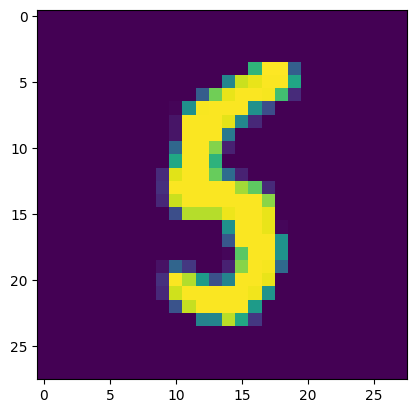

In [42]:
import matplotlib.pyplot as plt
plt.imshow(image_batch[1][0])
print(model(image_batch)[1])